In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [2]:
dfs = []
for tsv in ["../results/subj.tsv", "../results/ag_news.tsv", "../results/imdb.tsv", "../results/enron.tsv", "../results/amazon_cf.tsv", "../results/toxic_conversations.tsv", "../results/tweet_abortion.tsv", "../results/mrpc.tsv"]:
    dfs.append(pd.read_csv(tsv, delimiter="\t"))
all_df = pd.concat(dfs)

In [3]:
# F1 between 0 and 100
all_df["dec-f1"] = all_df["dec-f1"] * 100
all_df["lr-f1"] = all_df["lr-f1"] * 100

# Is it better to use the few annotated examples to train few-shot models or to generate synthetic data and train few-shot models with it?

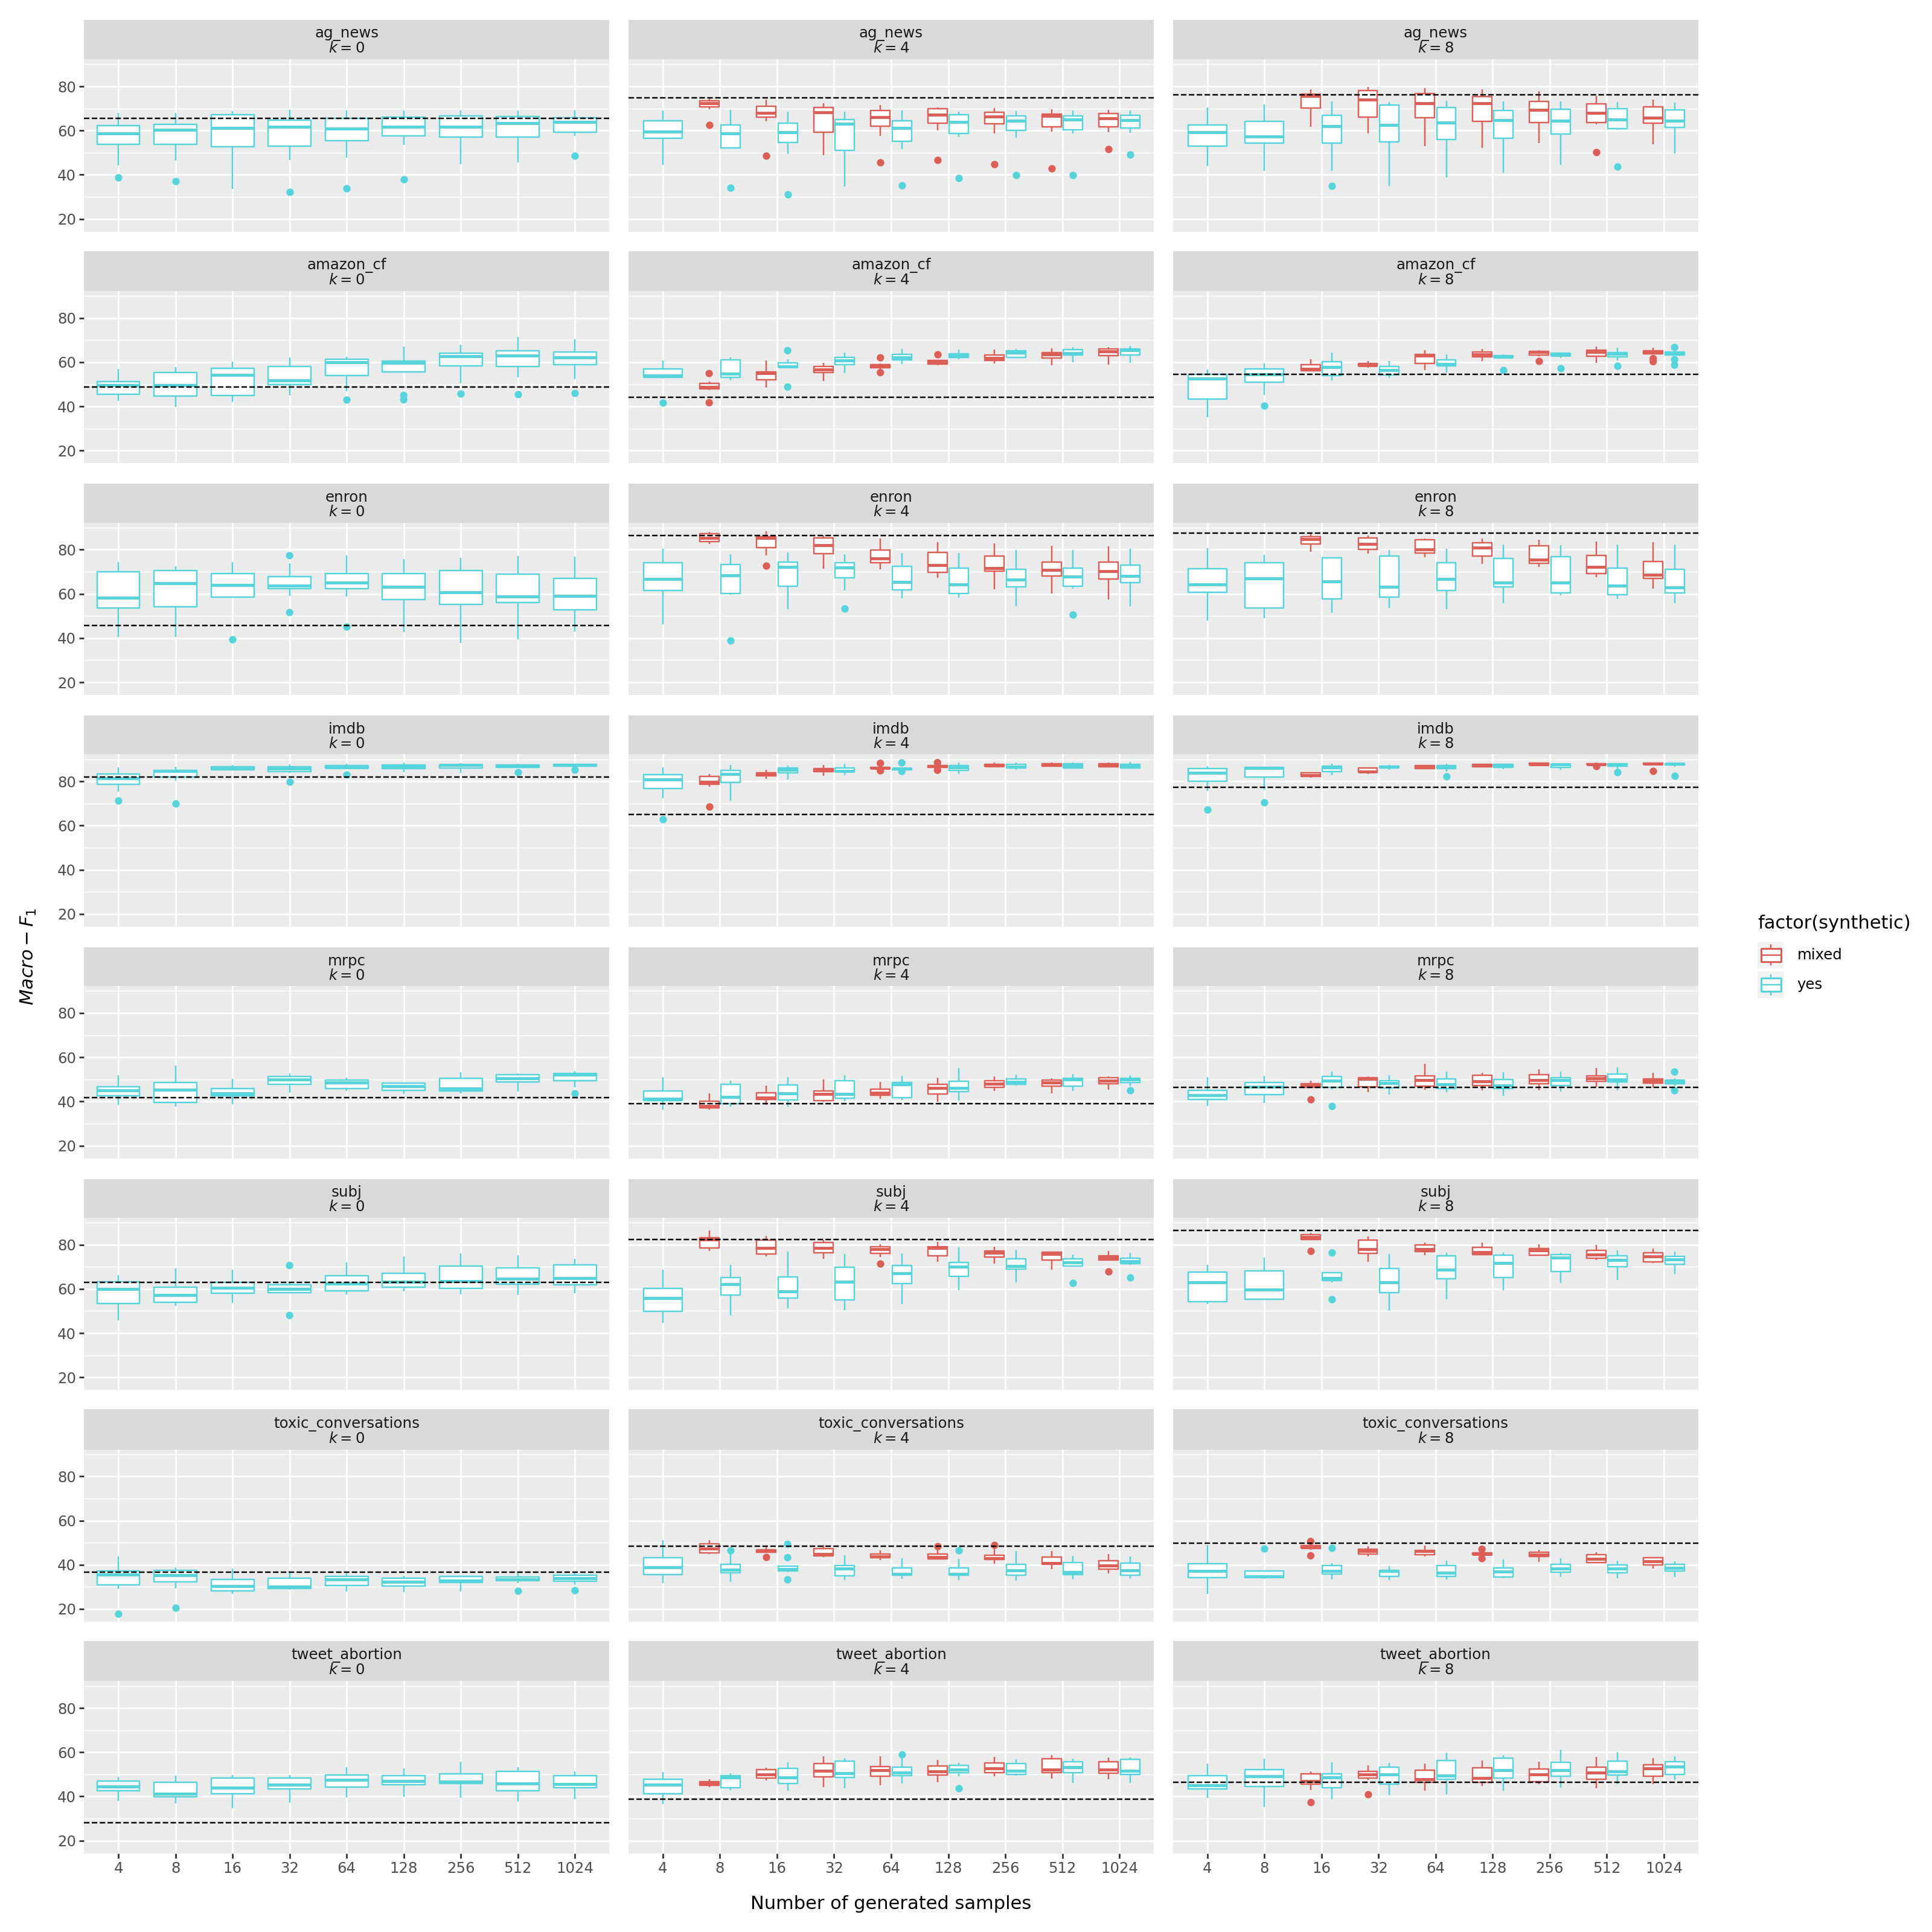

In [ ]:
from plotnine import *

# Define the unique datasets and conditions
datasets = ["ag_news", "imdb", "subj", "enron", "amazon_cf", "toxic_conversations", "tweet_abortion", "mrpc"]
conditions = [0, 4, 8]

# Build the datasets and conditions lists
datasets_expanded = [dataset for dataset in datasets for _ in conditions]
condition_expanded = [f"$k={k}$" for _ in datasets for k in conditions]

# Extract y-intercept values
yintercept = [
    all_df[(all_df["synthetic"] == "no") & (all_df["numsamples"] == k) & (all_df["dataset"] == dataset)]["dec-f1"].iloc[0]
    for dataset in datasets
    for k in conditions
]

# Convert the dictionary to a DataFrame to use in geom_hline
line_df = pd.DataFrame({
    'dataset': datasets_expanded,
    "condition": condition_expanded,
    'yintercept': yintercept
})

# Filter and label each subset with a new 'condition' column
df_0 = all_df[(all_df["icexamples"] == 0)].copy()
df_0["condition"] = "$k=0$"

df_4 = all_df[(all_df["icexamples"] == 4)].copy()
df_4["condition"] = "$k=4$"

df_8 = all_df[(all_df["icexamples"] == 8)].copy()
df_8["condition"] = "$k=8$"

# Concatenate all subsets into a single DataFrame
df_combined = pd.concat([df_0, df_4, df_8])


# Create the plot
(
    ggplot(df_combined, aes("factor(numsamples)", "dec-f1", color="factor(synthetic)"))
    + geom_boxplot()
    + geom_hline(aes(yintercept='yintercept'), data=line_df, linetype="dashed", color="black")  # Add dataset-specific lines
    + facet_wrap(["dataset", "condition"], nrow=len(datasets))
    + theme(
        figure_size=(16, 16)
    )
    + xlab("Number of generated samples")
    + ylab("$Macro-F_1$")
)

Q1: If I have n human annotated examples, it is better to train a few-shot model with them, or use them as ICE to generate synthetic data?

Q2: how many samples must I generate to outperform the few-shot model trained with human-annotated examples?

Q3: The more synthetic data the better?

# Comparison including >8 shots

Even with the best configuration for each dataset, using >8 real samples to train few-shot models outperforms the usage of synthetic data.

In [19]:
real_results = all_df[all_df["synthetic"] == "no"]
synthetic_results = all_df[all_df["synthetic"] == "yes"]
mixed_results = all_df[all_df["synthetic"] == "mixed"]

# Get the best results using synthetic data
grouped = synthetic_results.groupby("dataset")
best_synthetic = [{"dataset": dataset, "f1": group["dec-f1"].max(), "numsamples": "best-synthetic"} for dataset, group in grouped]
df_synthetic = pd.DataFrame(best_synthetic)

# Get the best results using mixed data
grouped = mixed_results.groupby("dataset")
best_mixed = [{"dataset": dataset, "f1": group["dec-f1"].max(), "numsamples": "best-mixed"} for dataset, group in grouped]
df_mixed = pd.DataFrame(best_mixed)

# Mod real results
real_results = real_results[["dataset", "dec-f1", "numsamples"]].rename(columns={"dec-f1": "f1"})
real_results["numsamples"] = real_results["numsamples"].map(lambda x: f"real-{x}")

df = pd.concat((df_synthetic, df_mixed, real_results))


      dataset         f1      numsamples marker
0     ag_news  73.554228  best-synthetic      x
1   amazon_cf  71.537436  best-synthetic      x
2       enron  82.348725  best-synthetic      x
3        imdb  88.674803  best-synthetic      x
4        mrpc  56.134784  best-synthetic      x
..        ...        ...             ...    ...
5        mrpc  53.909239         real-64      o
6        mrpc  50.949014         real-32      o
7        mrpc  52.558140         real-16      o
8        mrpc  46.486330          real-8      o
9        mrpc  38.952618          real-4      o

[96 rows x 4 columns]


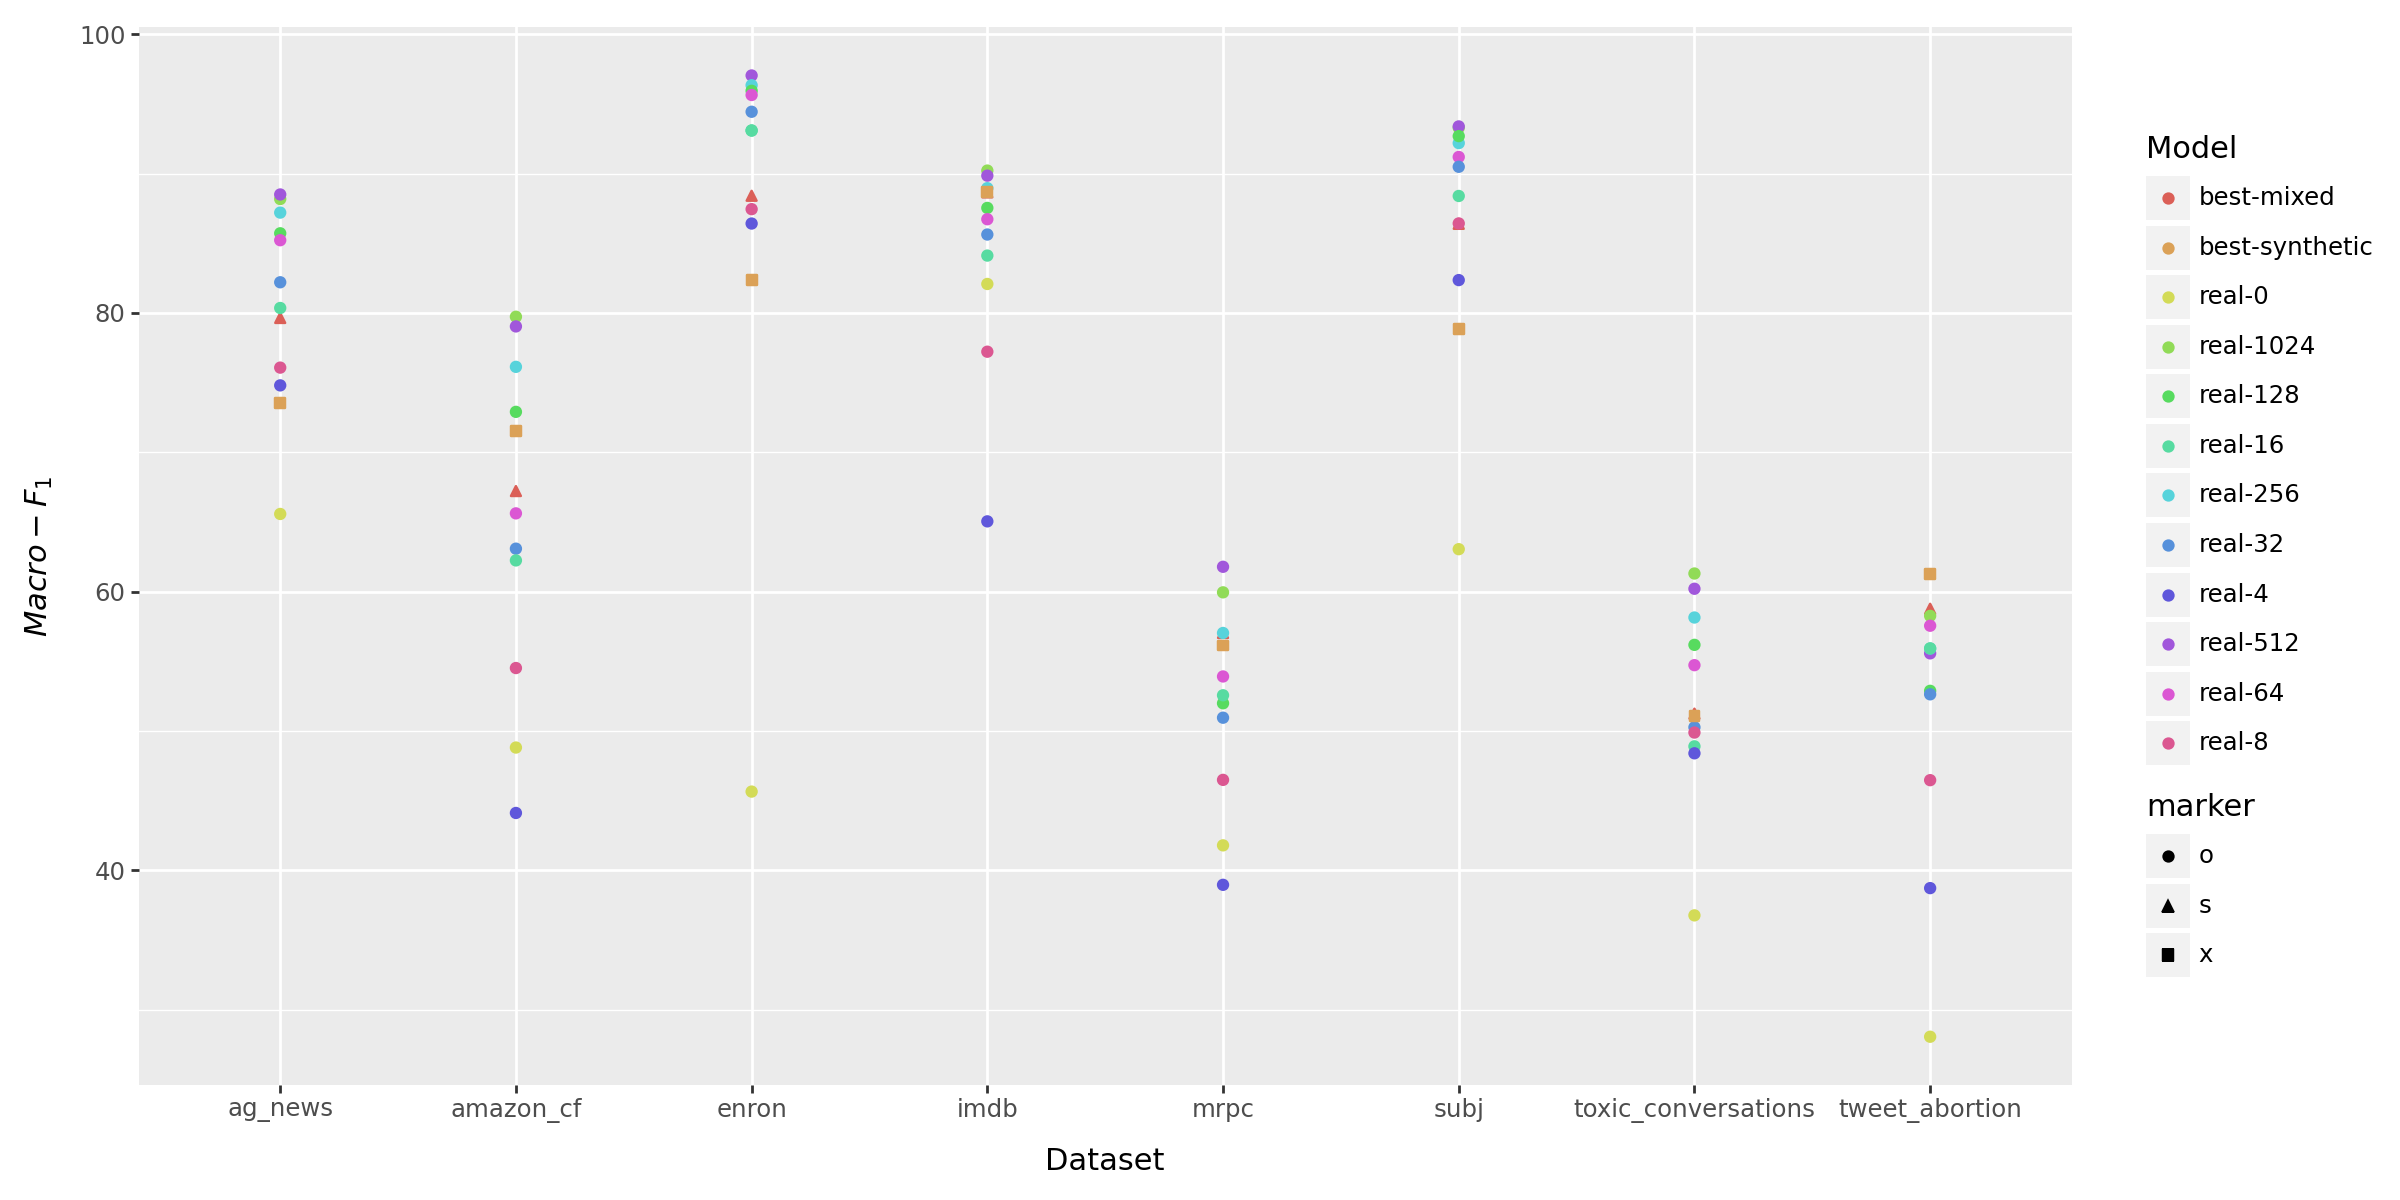

In [ ]:
df["marker"] = df["numsamples"].map({
    "best-synthetic": "x",
    "best-mixed": "s",
    "real-0": "o",
    "real-4": "o",
    "real-8": "o",
    "real-16": "o",
    "real-32": "o",
    "real-64": "o",
    "real-128": "o",
    "real-256": "o",
    "real-512": "o",
    "real-1024": "o",
})

print(df)

(
    ggplot(df, aes("dataset", "f1", color="numsamples", shape="marker"))
    + geom_point()
    + theme(
        figure_size=(12, 6)
    )
    + xlab("Dataset")
    + ylab("$Macro-F_1$")
    + labs(color = 'Model')
)

# Ablation of pipeline components (personas, topics, and evaluator)

## Personas

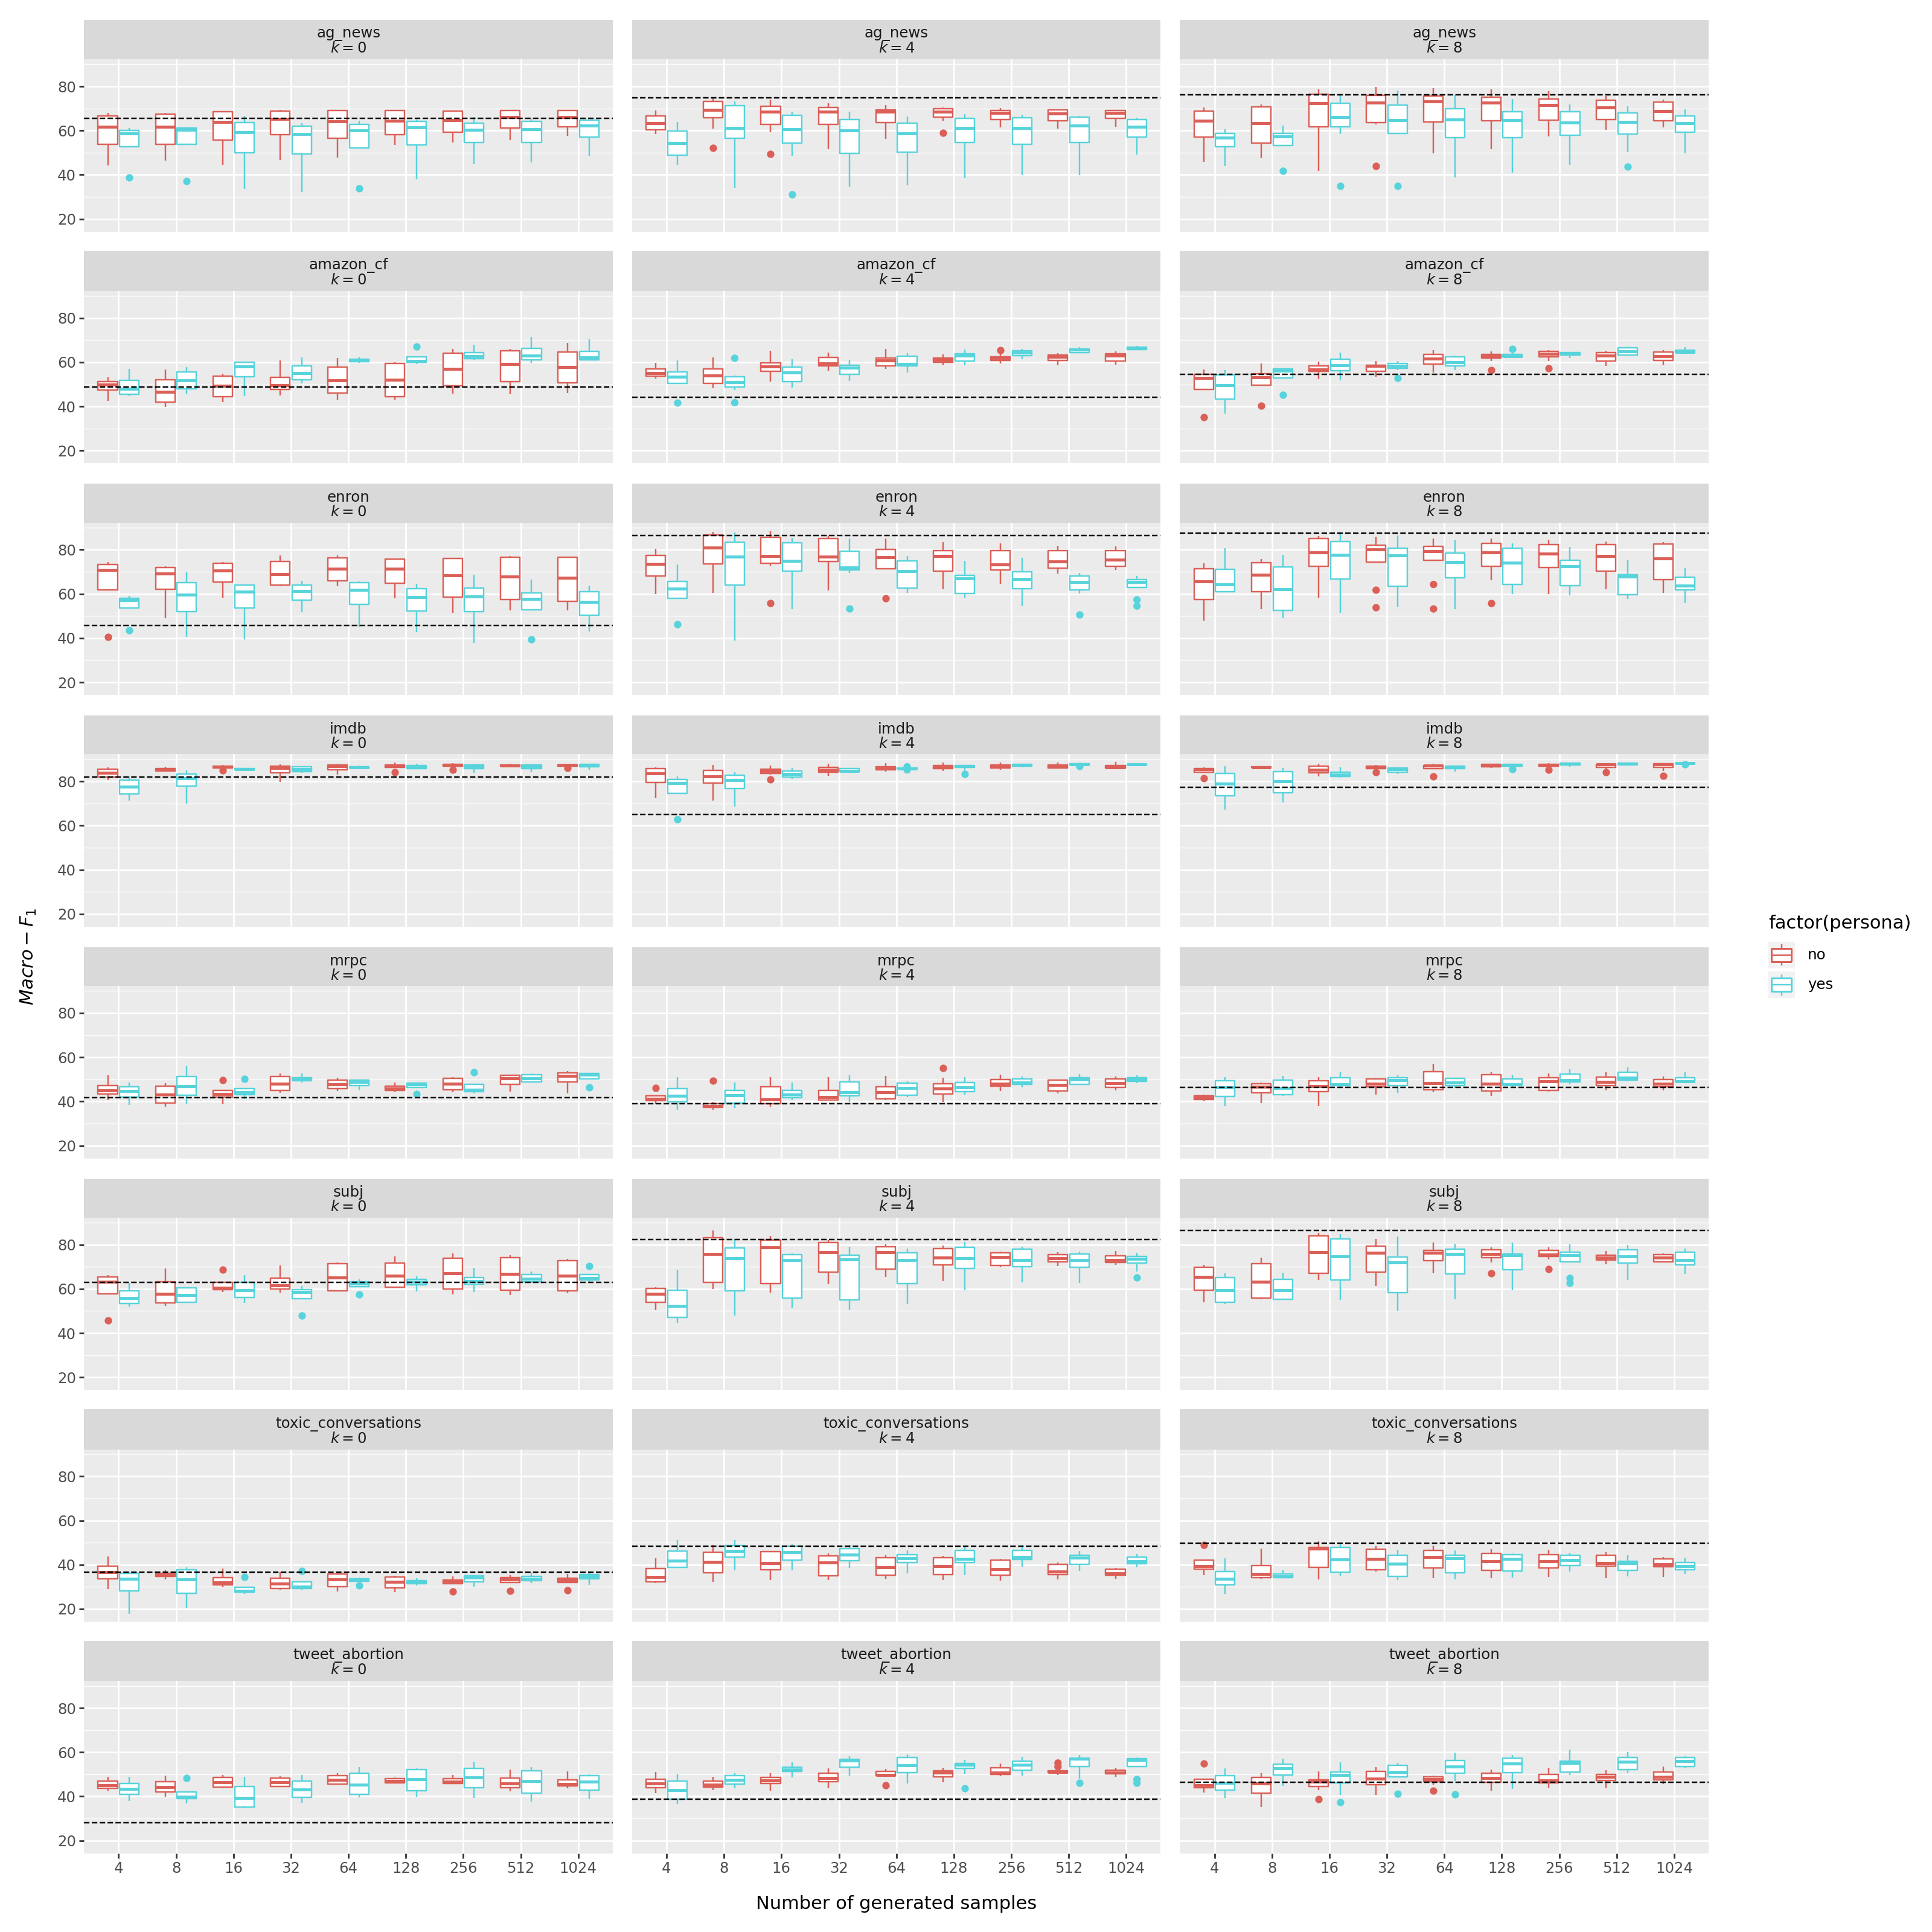

In [5]:
# Define the unique datasets and conditions
datasets = ["ag_news", "imdb", "subj", "enron", "amazon_cf", "toxic_conversations", "tweet_abortion", "mrpc"]
conditions = [0, 4, 8]

# Build the datasets and conditions lists
datasets_expanded = [dataset for dataset in datasets for _ in conditions]
condition_expanded = [f"$k={k}$" for _ in datasets for k in conditions]

# Extract y-intercept values with a list comprehension
yintercept = [
    all_df[(all_df["synthetic"] == "no") & (all_df["numsamples"] == k) & (all_df["dataset"] == dataset)]["dec-f1"].iloc[0]
    for dataset in datasets
    for k in conditions
]

# Convert the dictionary to a DataFrame to use in geom_hline
line_df = pd.DataFrame({
    'dataset': datasets_expanded,
    "condition": condition_expanded,
    'yintercept': yintercept
})

df = all_df[all_df["synthetic"].isin(["yes", "mixed"])]


(
    ggplot(df_combined, aes("factor(numsamples)", "dec-f1", color="factor(persona)"))
    + geom_boxplot()
    + geom_hline(aes(yintercept='yintercept'), data=line_df, linetype="dashed", color="black")  # Add dataset-specific lines
    + facet_wrap(["dataset", "condition"], nrow=len(datasets))
    + theme(
        figure_size=(16, 16)
    )
    + xlab("Number of generated samples")
    + ylab("$Macro-F_1$")
)

In [6]:
# Per synthetic type
all_df.groupby(["synthetic", "persona"])["dec-f1"].mean()

synthetic  persona
mixed      no         64.232769
           yes        63.291322
yes        no         59.096937
           yes        57.309528
Name: dec-f1, dtype: float64

In [7]:
# For all kind of synthetic
all_df[all_df["synthetic"].isin(["yes", "mixed"])].groupby("persona")["dec-f1"].mean()

persona
no     60.931162
yes    59.445883
Name: dec-f1, dtype: float64

Q1: Do personas help to improve performance?

## Topics

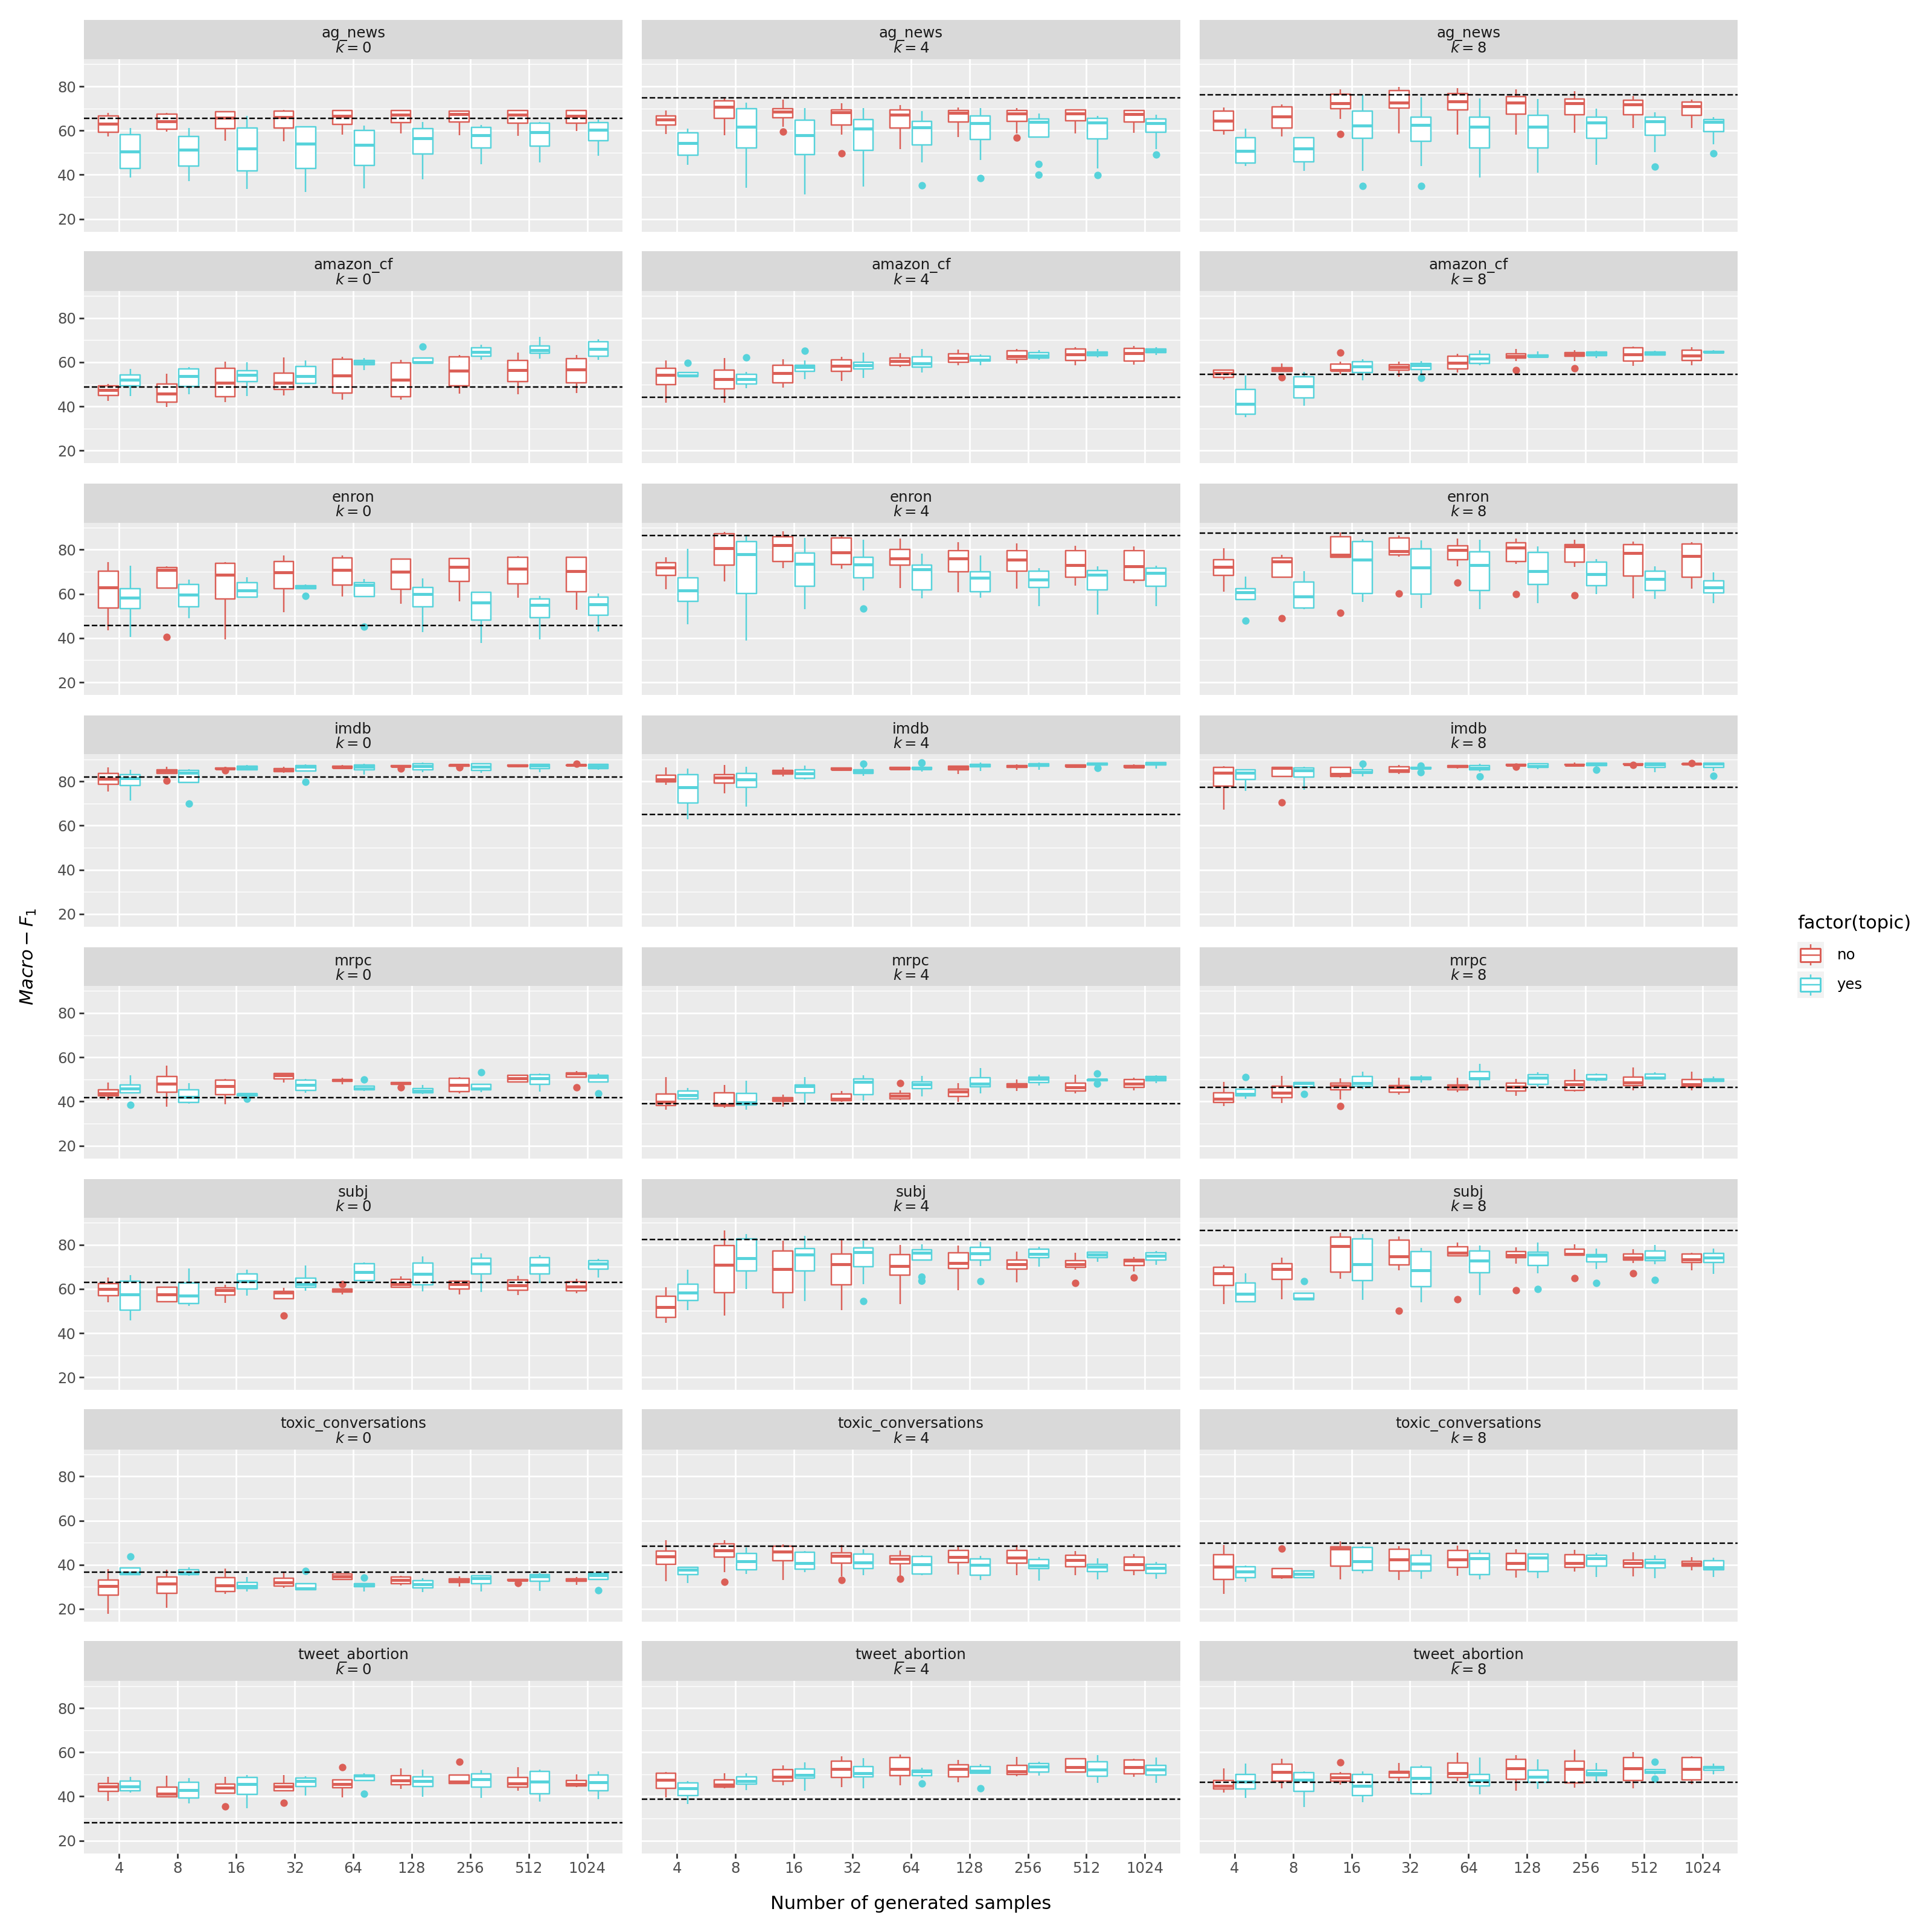

In [8]:
(
    ggplot(df_combined, aes("factor(numsamples)", "dec-f1", color="factor(topic)"))
    + geom_boxplot()
    + geom_hline(aes(yintercept='yintercept'), data=line_df, linetype="dashed", color="black")  # Add dataset-specific lines
    + facet_wrap(["dataset", "condition"], nrow=len(datasets))
    + theme(
        figure_size=(16, 16)
    )
    + xlab("Number of generated samples")
    + ylab("$Macro-F_1$")
)

In [9]:
# Per synthetic type
all_df.groupby(["synthetic", "topic"])["dec-f1"].mean()

synthetic  topic
mixed      no       64.445816
           yes      63.078275
yes        no       59.353622
           yes      57.052843
Name: dec-f1, dtype: float64

In [10]:
# For all kind of synthetic
all_df[all_df["synthetic"].isin(["yes", "mixed"])].groupby("topic")["dec-f1"].mean()

topic
no     61.172263
yes    59.204783
Name: dec-f1, dtype: float64

Q1: Do topics help to improve performance?

## Evaluator

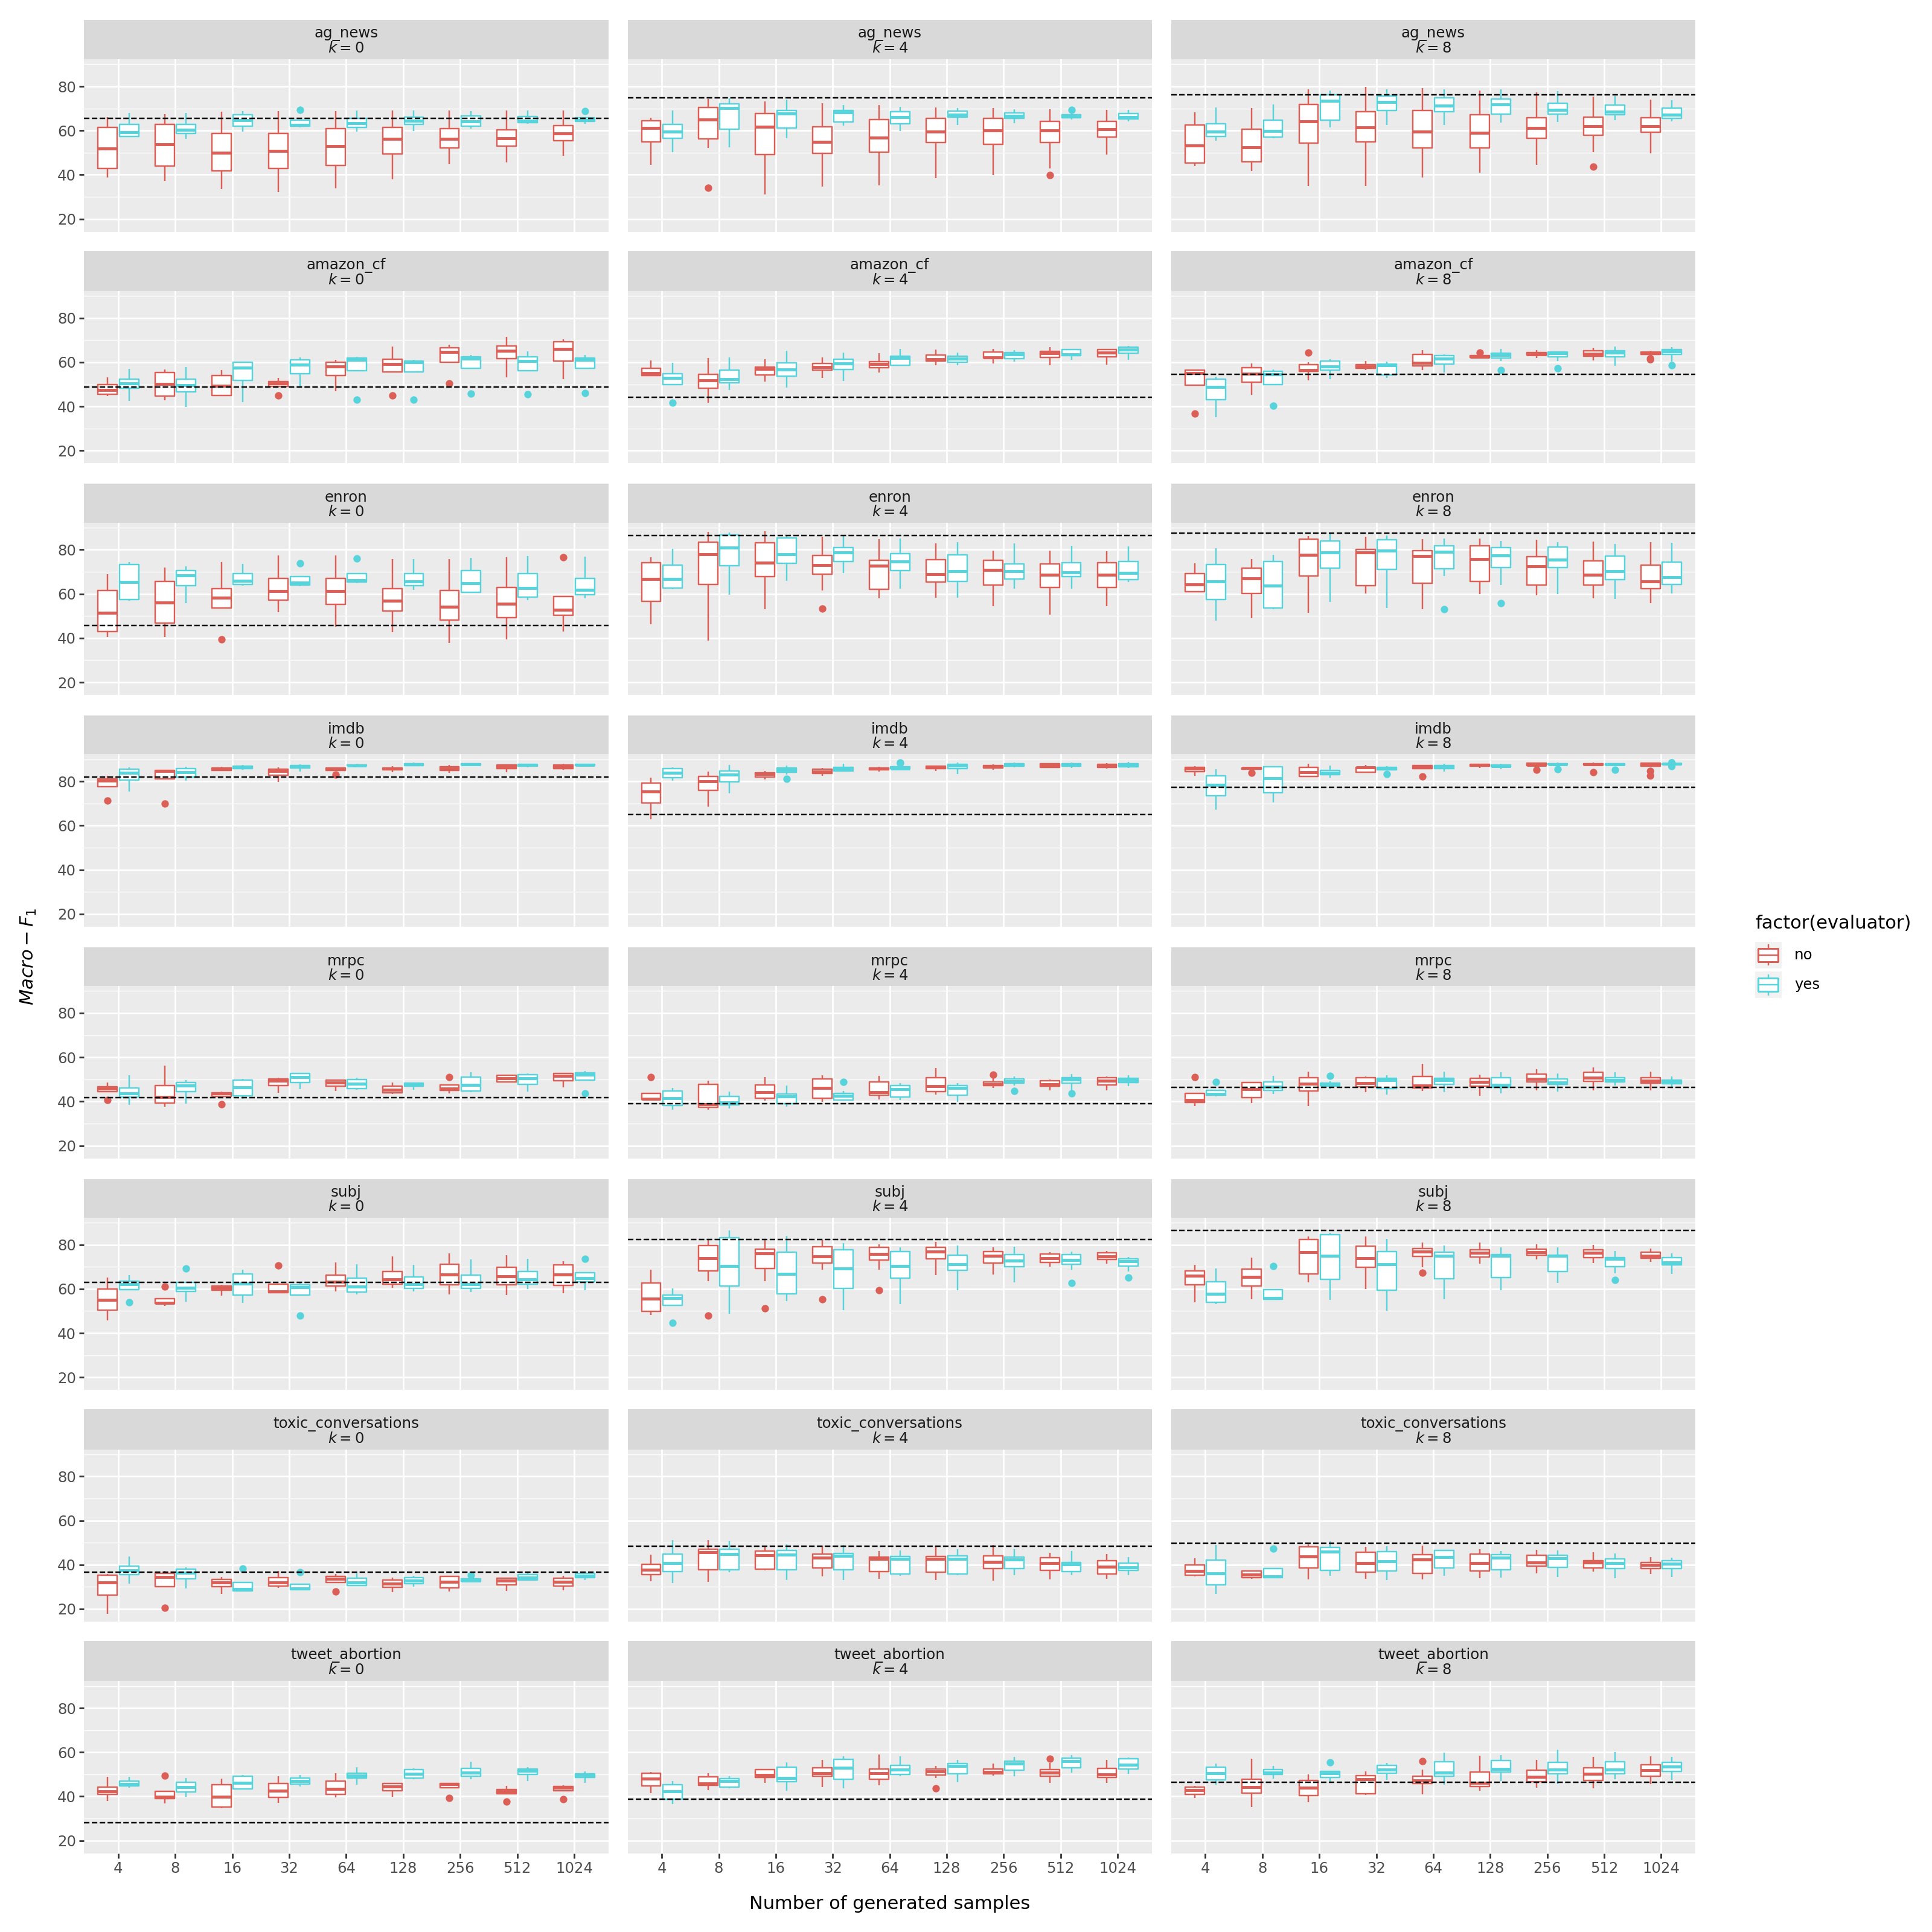

In [11]:
(
    ggplot(df_combined, aes("factor(numsamples)", "dec-f1", color="factor(evaluator)"))
    + geom_boxplot()
    + geom_hline(aes(yintercept='yintercept'), data=line_df, linetype="dashed", color="black")  # Add dataset-specific lines
    + facet_wrap(["dataset", "condition"], nrow=len(datasets))
    + theme(
        figure_size=(16, 16)
    )
    + xlab("Number of generated samples")
    + ylab("$Macro-F_1$")
)

In [12]:
# Per synthetic type
all_df.groupby(["synthetic", "evaluator"])["dec-f1"].mean()

synthetic  evaluator
mixed      no           63.028863
           yes          64.495228
yes        no           57.195577
           yes          59.210888
Name: dec-f1, dtype: float64

In [13]:
# For all type of synthetic
all_df[all_df["synthetic"].isin(["yes", "mixed"])].groupby("evaluator")["dec-f1"].mean()

evaluator
no     59.278893
yes    61.098152
Name: dec-f1, dtype: float64

Q1: Do evaluators help to improve performance?

# JSD between synthetic and real


Computes and plots:

- The JSD among all the concatenated synthetic data and the real data (test)
- The JSD divergence between the train and test splits of the dataset (only real data).

In [10]:
from datasets import load_from_disk
from pathlib import Path
import sys
sys.path.insert(0, "..")
from utils import compute_jsd
from configs import mapping

/data/research/sharedData/conda_envs/jgonzalez-datamaker/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/data/research/sharedData/conda_envs/jgonzalez-datamaker/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in OpenAIConfig has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.

In [11]:
def compute_task_jsd(task_name):
    cls_ = mapping[task_name]
    ds_real = cls_.dataset
    real_train_text = ds_real["train"]["text"]
    real_test_text = ds_real["test"]["text"]

    path = Path(f"../cache/{task_name}")
    concat_synthetic = []

    for path in path.iterdir():
        ds_synthetic = load_from_disk(path)
        x_synthetic = ds_synthetic["text"]
        concat_synthetic += x_synthetic

    # Get delta between best real and best synthetic f1
    best_f1_real = all_df[(all_df["synthetic"] == "no") & (all_df["numsamples"] <= 8) & (all_df["dataset"] == task_name)]["dec-f1"].max()
    best_f1_synthetic = all_df[(all_df["synthetic"].isin(["yes", "mixed"])) & (all_df["dataset"] == task_name)]["dec-f1"].max()
    delta = round(best_f1_synthetic - best_f1_real, 2)

    data = {"Synthetic-Real": [compute_jsd(concat_synthetic, real_test_text)],
            "Train-Test": [compute_jsd(real_train_text, real_test_text)],
            "Δf1": [delta],
            "dataset": [task_name]}
    return pd.DataFrame(data)

def compute_tasks_jsd():
    dfs = []
    ds_path = Path(f"../cache/")
    for folder in ds_path.iterdir():
        if not folder.is_dir():
            continue
        task_name = folder.as_posix().split("/")[-1]
        dfs.append(compute_task_jsd(task_name))
    return pd.concat(dfs)

jsd_df = compute_tasks_jsd()

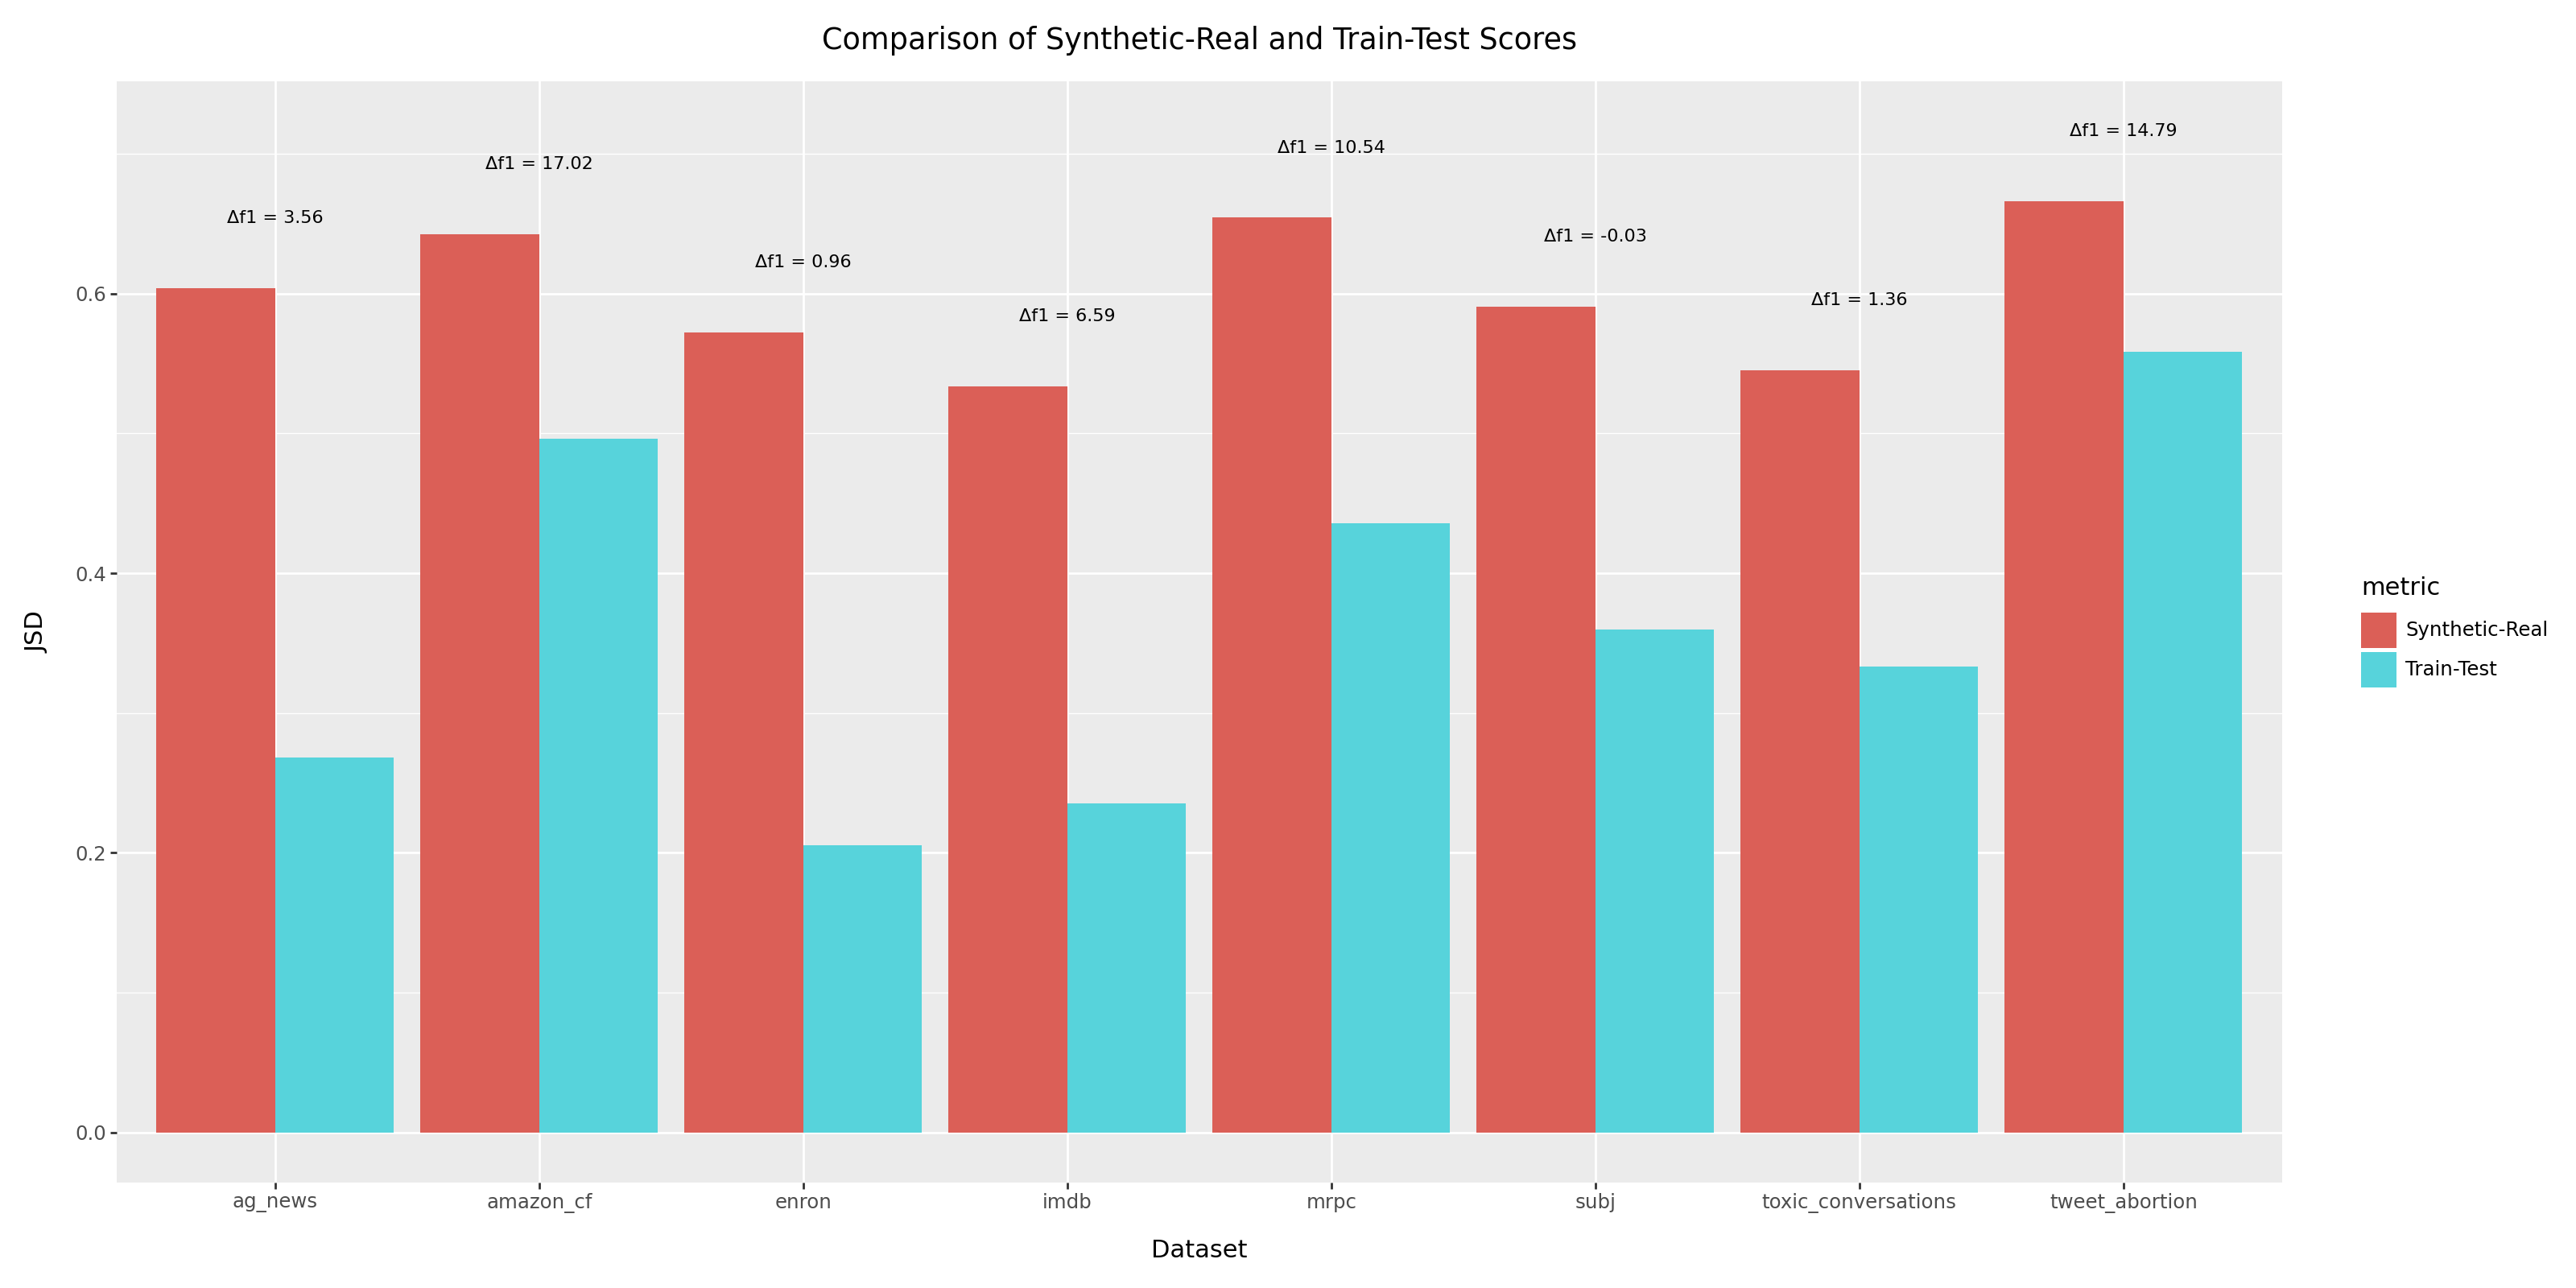

In [12]:
# Reshaping the dataframe
df_long = jsd_df.melt(id_vars=["dataset", "Δf1"], var_name="metric", value_name="score")

# Filter only rows where the metric is 'Synthetic-Real' for annotations
df_long_annotate = df_long[df_long["metric"] == "Synthetic-Real"]

# Plot
(
    ggplot(df_long, aes(x="factor(dataset)", y="score", fill="metric"))
    + geom_col(position="dodge")  # Bar plot
    + geom_text(
        df_long_annotate,
        aes(
            label=[f"Δf1 = {val:.2f}" for val in df_long_annotate['Δf1']],
            y=df_long_annotate['score'] + 0.05
        ),
        size=8
    )
    + theme(figure_size=(16, 8))  # Adjust figure size
    + labs(
        x="Dataset",
        y="JSD",
        title="Comparison of Synthetic-Real and Train-Test Scores"
    )
)

## Same than above, but just focusing on the best configuration

In [21]:
from datasets import load_from_disk
from pathlib import Path
import sys
sys.path.insert(0, "..")
from utils import compute_jsd
from configs import mapping

In [22]:
def get_config_name(df_row):
    name = []
    for column, val in df_row.to_dict().items():
        if column not in ["dataset", "dec-f1", "lr-f1", "synthetic", "numsamples"]:
            if type(val) == float:
                val = int(val)
            name.append(f"{column}+{val}")
    name.append(f"numsamples+1024")
    return "_".join(name)

In [43]:
def compute_task_jsd(task_name, config_name):
    cls_ = mapping[task_name]
    ds_real = cls_.dataset
    real_train_text = ds_real["train"]["text"]
    real_test_text = ds_real["test"]["text"]

    path = Path(f"../cache/{task_name}/{config_name}")

    ds_synthetic = load_from_disk(path)
    x_synthetic = ds_synthetic["text"]

    data = {"Synthetic-Real": [compute_jsd(x_synthetic, real_test_text)],
            "Train-Test": [compute_jsd(real_train_text, real_test_text)],
            "dataset": [task_name]}
    return pd.DataFrame(data)

def compute_tasks_jsd():
    dfs = []
    # Compute JSD for the best configuration in each dataset
    synthetic_df = all_df[all_df["synthetic"].isin(["yes", "mixed"])]
    groups = synthetic_df.groupby("dataset")
    for task_name, group_df in groups:
        # Compute the JSD
        config = group_df.loc[group_df["dec-f1"].idxmax()]
        config_name = get_config_name(config)
        df = compute_task_jsd(task_name, config_name)
        # Get delta between best real and best synthetic f1
        best_f1_real = all_df[(all_df["synthetic"] == "no") & (all_df["numsamples"] <= 8) & (all_df["dataset"] == task_name)]["dec-f1"].max()
        best_f1_synthetic = config["dec-f1"]
        delta = round(best_f1_synthetic - best_f1_real, 2)
        df["Δf1"] = [delta]
        dfs.append(df)
        
    return pd.concat(dfs)
jsd_df = compute_tasks_jsd()

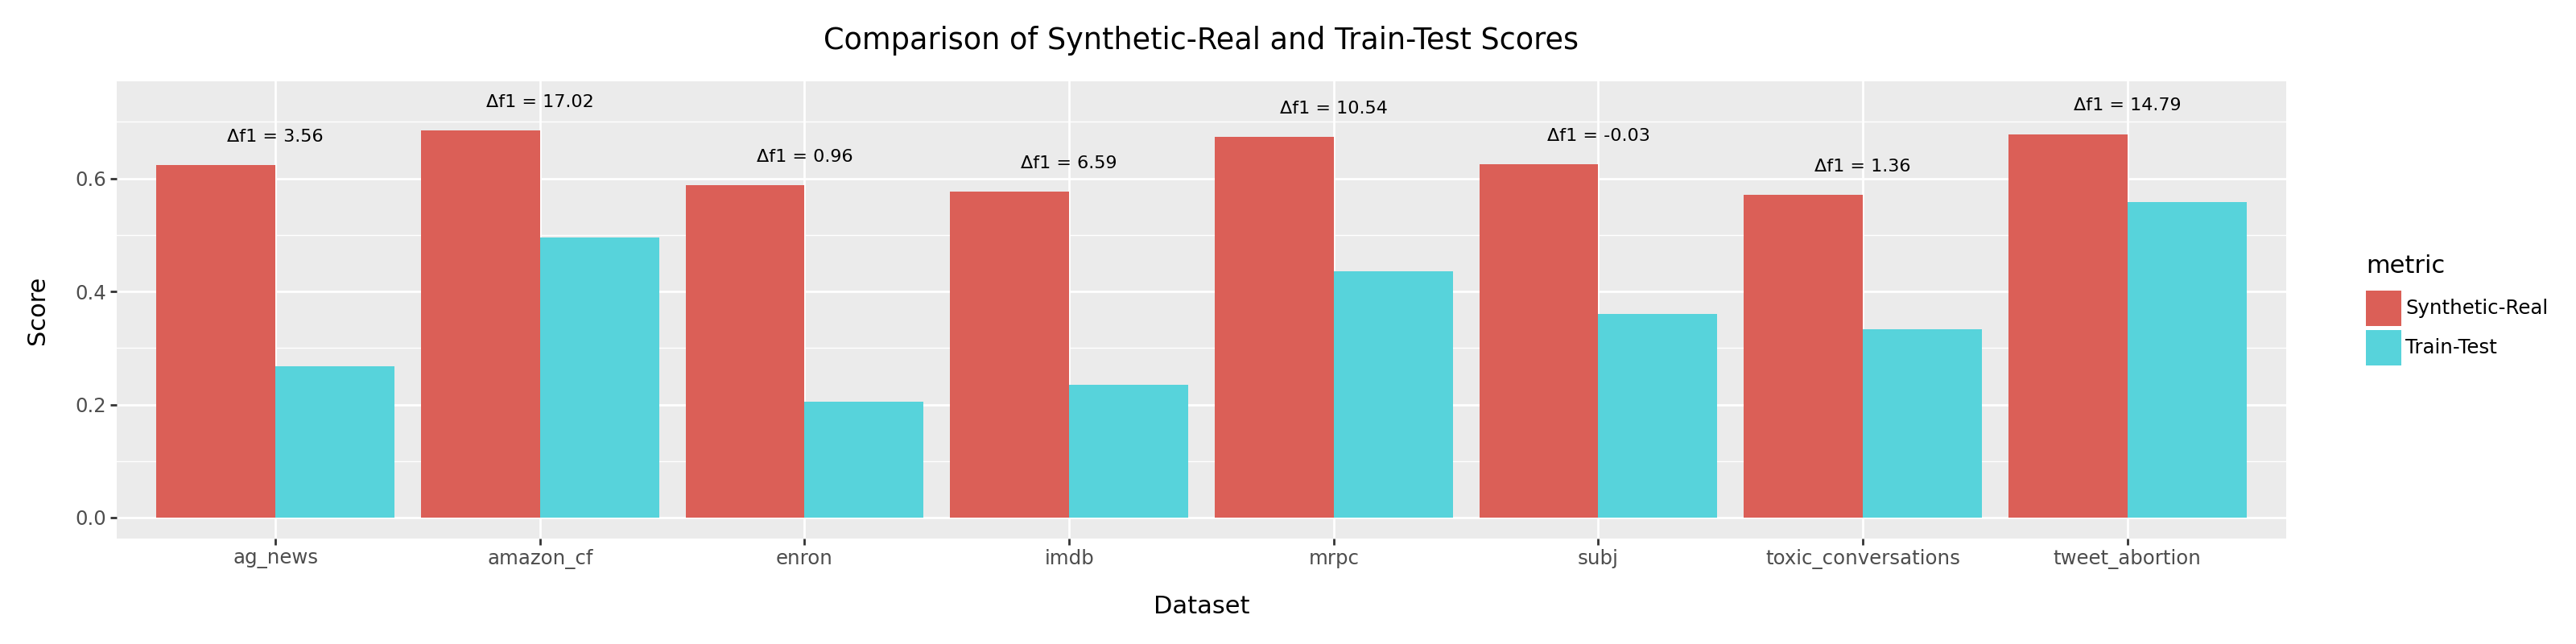

In [44]:
# Reshaping the dataframe
df_long = jsd_df.melt(id_vars=["dataset", "Δf1"], var_name="metric", value_name="score")

# Filter only rows where the metric is 'Synthetic-Real' for annotations
df_long_annotate = df_long[df_long["metric"] == "Synthetic-Real"]

# Plot
(
    ggplot(df_long, aes(x="factor(dataset)", y="score", fill="metric"))
    + geom_col(position="dodge")  # Bar plot
    + geom_text(
        df_long_annotate,
        aes(
            label=[f"Δf1 = {val:.2f}" for val in df_long_annotate['Δf1']],
            y=df_long_annotate['score'] + 0.05
        ),
        size=8
    )
    + theme(figure_size=(16, 4))  # Adjust figure size
    + labs(
        x="Dataset",
        y="Score",
        title="Comparison of Synthetic-Real and Train-Test Scores"
    )
)

# Label matching between most similar synthetic-real

WARNING: Rerun with all predictions, not just errors

Check label matching across all the predictions from all the experiments

In [4]:
from pathlib import Path

pred_path = Path("../predictions")
datasets = []

for fname in pred_path.rglob("*.tsv"):
    task_name = fname.as_posix().split("/")[2]
    df = pd.read_csv(fname, delimiter="\t")
    df["dataset"] = [task_name] * len(df)
    datasets.append(df)
dataset = pd.concat(datasets)

In [5]:
grouped = dataset.groupby("dataset")
results = {}
for task_name, group_df in grouped:
    errors = group_df[group_df["reference"] != group_df["most_similar_synthetic_label"]]
    matches = group_df[group_df["reference"] == group_df["most_similar_synthetic_label"]]
    results[task_name] = len(matches) / (len(errors) + len(matches))

matches_df = pd.DataFrame({"dataset": results.keys(), "match %": results.values()})

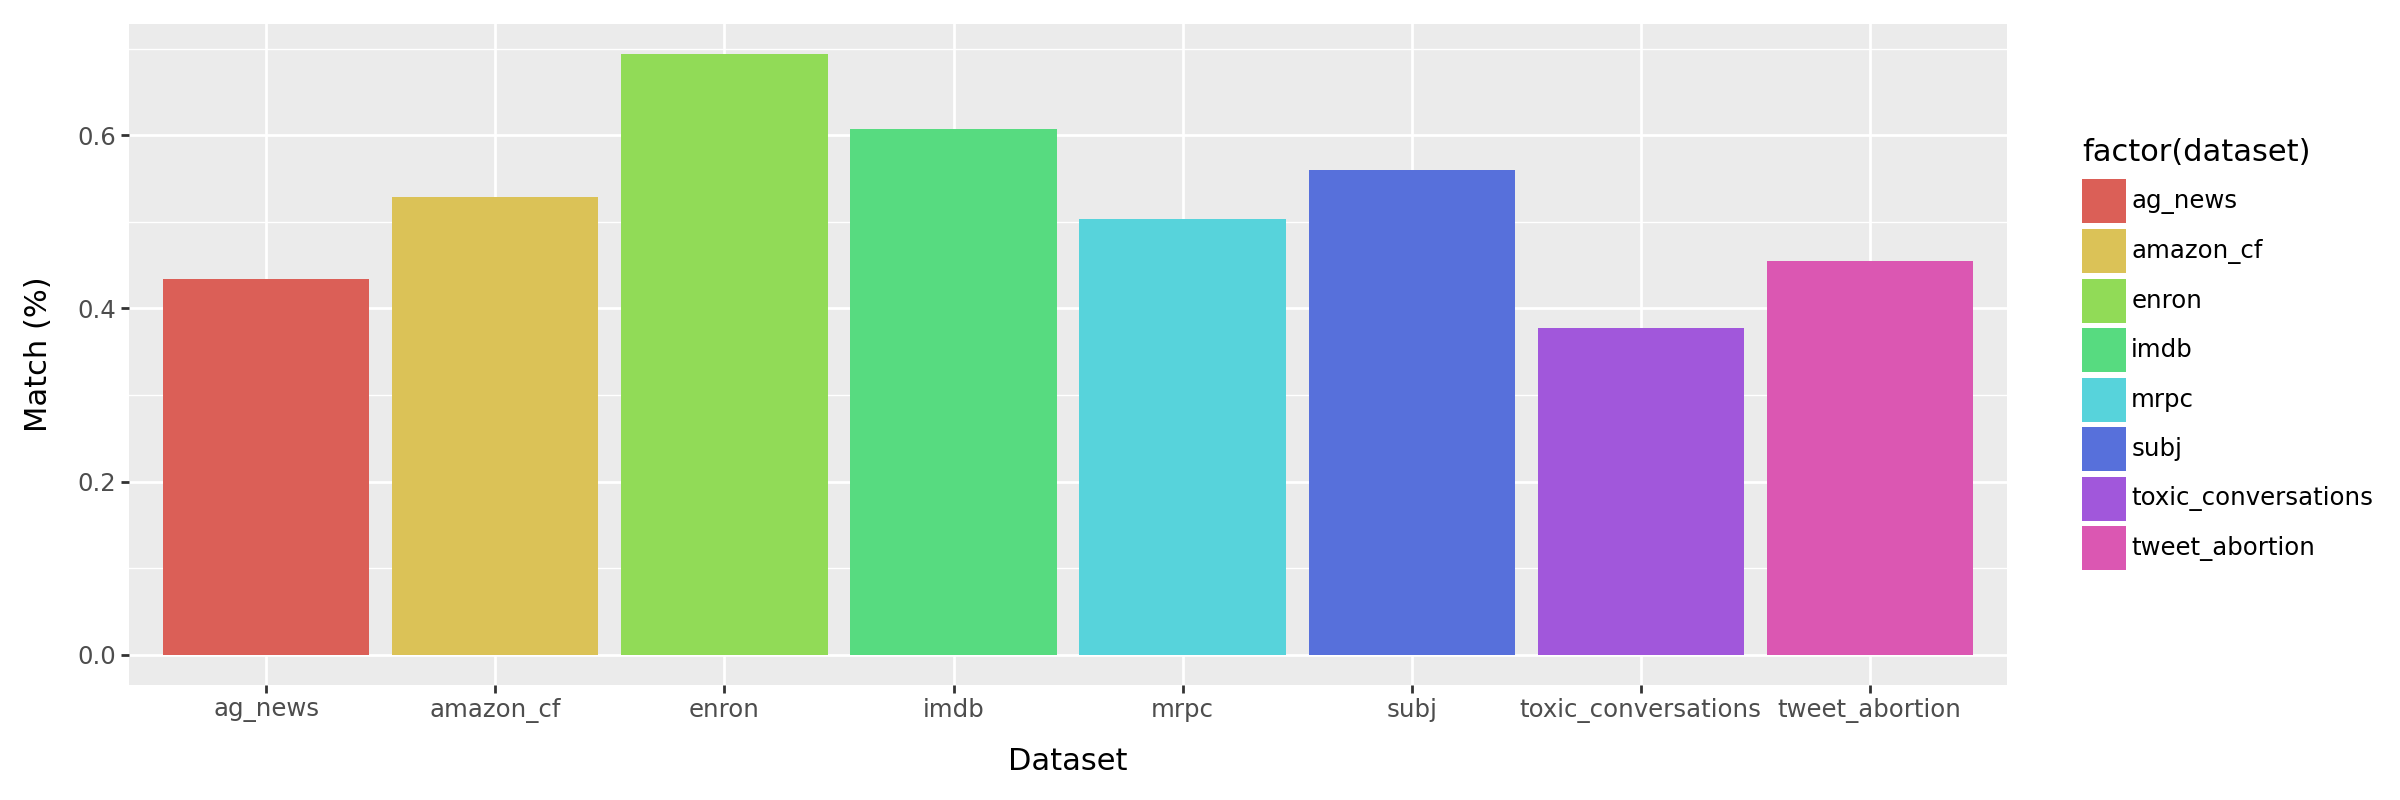

In [6]:
(
    ggplot(matches_df, aes(x="factor(dataset)", y="match %", fill="factor(dataset)"))
    + geom_col(position="dodge")  # Bar plot
    + theme(figure_size=(12, 4))  # Adjust figure size
    + labs(
        x="Dataset",
        y="Match (%)",
    )
)

# Dataset diversity

- Inter/Intra/Mean APS (https://openreview.net/pdf?id=6hZIfAY9GD)

- Vocabulary sizes

## Vocabulary sizes

In [ ]:
from collections import Counter

def get_vocab_sizes(task_name):
    path = Path(f"../cache/{task_name}")
    results = {}

    # Compute vocab sizes for synthetic data
    for path in path.iterdir():
        config = path.as_posix().split("/")[-1]
        ds_synthetic = load_from_disk(path)
        df_synthetic = ds_synthetic.to_pandas()
        # Get all vocab
        all_vocab = len(set(" ".join(df_synthetic["text"]).split()))
        # Get avg label vocab
        grouped = df_synthetic.groupby("completion")
        vocab_per_label = []
        for _, group_df in grouped:
            vocab_per_label.append(len(set(" ".join(group_df["text"]).split())))
        results[config] = {"all_vocab": all_vocab,
                           "class_avg": sum(vocab_per_label) / len(vocab_per_label)}

    # Compute vocab sizes for real texts (pick 1024 samples to match the length of the synthetic)
    cls_ = mapping[task_name]
    ds_real = cls_.dataset
    real_train_text = ds_real["train"]["text"][:1024]
    real_test_text = ds_real["test"]["text"][:1024]
    real_text = real_train_text + real_test_text
    real_labels = ds_real["train"]["completion"][:1024] + ds_real["test"]["completion"][:1024]

    df = pd.DataFrame({"text": real_text, "completion": real_labels})
    grouped = df.groupby("completion")
    vocab_per_label = []
    for _, group_df in grouped:
        vocab_per_label.append(len(set(" ".join(group_df["text"]).split())))
    results["real"] = {"all_vocab": len(set(" ".join(real_text).split())),
                       "class_avg": sum(vocab_per_label) / len(vocab_per_label)}

    return results

results = get_vocab_sizes("imdb")

## Inter/Intra/Mean Pairwise similarity

In [7]:
from sentence_transformers import SentenceTransformer

DEC_MODEL_NAME_OR_PATH = "sentence-transformers/paraphrase-mpnet-base-v2"
ENCODER = SentenceTransformer(DEC_MODEL_NAME_OR_PATH)

/data/research/sharedData/conda_envs/jgonzalez-datamaker/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2024-11-19 14:12:29.980110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732021949.998502 3974496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732021950.004182 3974496 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:12:30.021427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in per

In [ ]:
from datasets import load_from_disk
import numpy as np
import sys
sys.path.insert(0, "..")
from configs import mapping

def aps(embeddings):
    stack = np.vstack(embeddings)
    norm_stack = stack / np.linalg.norm(stack, axis=-1, keepdims=True)
    cos_sims = (norm_stack @ norm_stack.T).flatten()
    aps = cos_sims.mean()
    return cos_sims, aps

def intra_class_aps(df):
    grouped = df.groupby("completion")
    intra_aps = []
    intra_cos_sims = []
    for _, group_df in grouped:
        cos_sims, aps_ = aps(group_df["embedding"])
        intra_aps.append(aps_)
        intra_cos_sims.append(cos_sims)
    intra_cos_sims = np.hstack(intra_cos_sims)
    return intra_cos_sims, np.mean(intra_aps)

def inter_class_aps(df):
    def f_inter_aps(embeddings_a, embeddings_b):
        stack_a = np.vstack(embeddings_a)
        stack_b = np.vstack(embeddings_b)
        norm_stack_a = stack_a / np.linalg.norm(stack_a, axis=-1, keepdims=True)
        norm_stack_b = stack_b / np.linalg.norm(stack_b, axis=-1, keepdims=True)
        cos_sims = (norm_stack_a @ norm_stack_b.T).flatten()
        aps = cos_sims.mean()
        return cos_sims, aps
    
    grouped = df.groupby("completion")
    labels = df["completion"].unique()
    inter_aps = []
    inter_cos_sims = []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            embeddings_a = grouped.get_group(labels[i])["embedding"]
            embeddings_b = grouped.get_group(labels[j])["embedding"]
            cos_sims, aps_ = f_inter_aps(embeddings_a, embeddings_b)
            inter_aps.append(aps_)
            inter_cos_sims.append(cos_sims)
    inter_cos_sims = np.hstack(inter_cos_sims)
    return inter_cos_sims, np.mean(inter_aps)

def compute_aps_for_task(task_name):
    path = Path(f"../cache/{task_name}")
    aps_results = []
    all_sims = []
    intra_sims = []
    inter_sims = []

    # Compute APS Intra/Inter
    for path in path.iterdir():
        config = path.as_posix().split("/")[-1]
        ds_synthetic = load_from_disk(path)
        x_synthetic = ds_synthetic["text"]
        labels = ds_synthetic["completion"]
        embeddings = ENCODER.encode(x_synthetic).tolist()
        df = pd.DataFrame({"embedding": embeddings, "completion": labels})
        all_cos_sims, all_aps = aps(df["embedding"])
        intra_cos_sims, intra_aps = intra_class_aps(df)
        try:
            inter_cos_sims, inter_aps = inter_class_aps(df)
        except:
            inter_cos_sims = None
            inter_aps = None
            print(f"Only one class was generated with the config: {config}")
        aps_results.append({"config": config, "aps": all_aps, "intra_aps": intra_aps, "inter_aps": inter_aps, "dataset": task_name})
        for sim in all_cos_sims:
            all_sims.append({"config": config, "sims": sim, "dataset": task_name})
        for sim in intra_cos_sims:
            intra_sims.append({"config": config, "sims": sim, "dataset": task_name})
        if inter_cos_sims is not None:
            for sim in inter_cos_sims:
                inter_sims.append({"config": config, "sims": sim, "dataset": task_name})           

    return pd.DataFrame(aps_results), pd.DataFrame(all_sims), pd.DataFrame(intra_sims), pd.DataFrame(inter_sims)

def compute_aps():
    datasets = ["ag_news", "imdb", "subj", "enron", "amazon_cf", "toxic_conversations", "tweet_abortion", "mrpc"]
    # Get APS and sims from real data
    aps_data = []
    all_sims = []
    intra_sims = []
    inter_sims = []
    for dataset in datasets:
        print(dataset)
        cls_ = mapping[dataset]
        cls_.dataset = cls_.dataset.shuffle(42)
        texts = cls_.dataset["test"]["text"][:1024]
        labels = cls_.dataset["test"]["completion"][:1024]
        embeddings = ENCODER.encode(texts).tolist()
        df = pd.DataFrame({"embedding": embeddings, "completion": labels})
        all_cos_sims, all_aps = aps(df["embedding"])
        intra_cos_sims, intra_aps = intra_class_aps(df)
        inter_cos_sims, inter_aps = inter_class_aps(df)
        aps_data.append({"config": None, "aps": all_aps, "intra_aps": intra_aps, "inter_aps": inter_aps, "dataset": dataset})
        for sim in all_cos_sims:
            all_sims.append({"config": None, "sims": sim, "dataset": dataset})
        for sim in intra_cos_sims:
            intra_sims.append({"config": None, "sims": sim, "dataset": dataset})
        for sim in inter_cos_sims:
            inter_sims.append({"config": None, "sims": sim, "dataset": dataset})
    results = {"real": {"aps": pd.DataFrame(aps_data), "all_sims": pd.DataFrame(all_sims), "intra_sims": pd.DataFrame(intra_sims), "inter_sims": pd.DataFrame(inter_sims)}}

    # Get APS and sims from synthetic data
    aps_dfs = []
    all_sims_dfs = []
    intra_sims_dfs = []
    inter_sims_dfs = []
    for dataset in datasets:
        print(dataset)
        aps_results, all_sims, intra_sims, inter_sims = compute_aps_for_task(dataset)
        aps_dfs.append(aps_results)
        all_sims_dfs.append(all_sims)
        intra_sims_dfs.append(intra_sims)
        inter_sims_dfs.append(inter_sims)
    results["synthetic"] = {"aps": pd.concat(aps_dfs), "all_sims": pd.concat(all_sims_dfs), "intra_sims": pd.concat(intra_sims_dfs), "inter_sims": pd.concat(inter_sims_dfs)}

    return results

results = compute_aps()


ag_news


KeyboardInterrupt: 

In [108]:
synthetic_aps_df = results["synthetic"]["aps"]
synthetic_aps_df["synthetic"] = "yes"
real_aps_df = results["real"]["aps"]
real_aps_df["synthetic"] = "no"
aps_df = pd.concat((synthetic_aps_df, real_aps_df))

/tmp/ipykernel_3974496/3647519992.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3974496/3647519992.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/research/sharedData/conda_envs/jgonzalez-datamaker/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


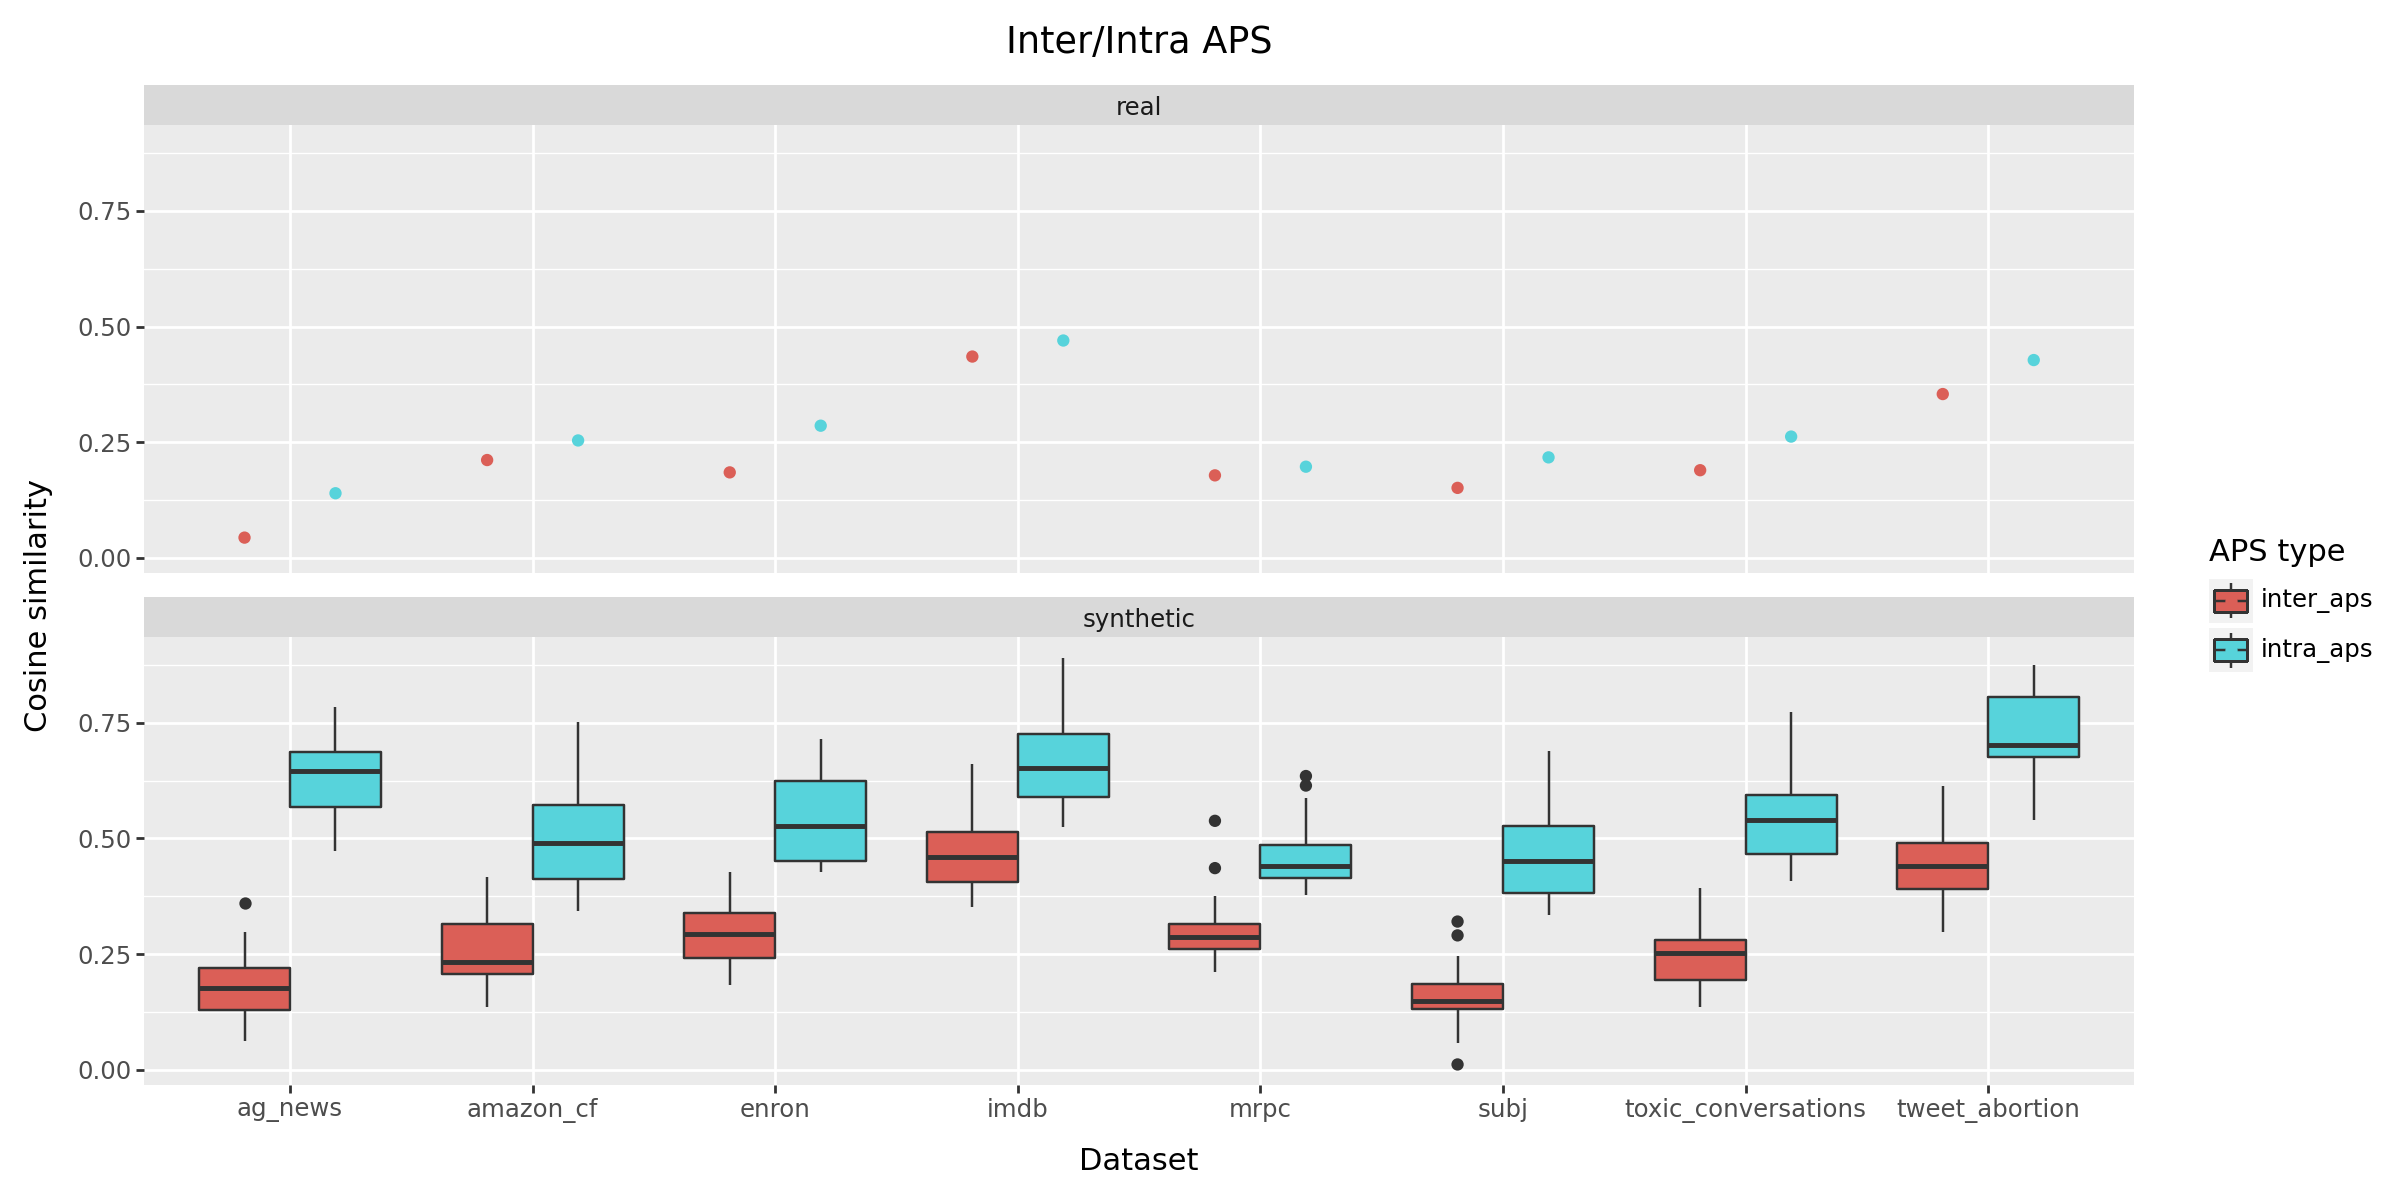

In [117]:
df_long = pd.melt(
    aps_df,
    id_vars=["config", "dataset", "synthetic"],
    value_vars=["intra_aps", "inter_aps"],
    var_name="metric",
    value_name="value",
)

# Split data for scatter and boxplot
scatter_data = df_long[df_long["synthetic"] == "no"]
boxplot_data = df_long[df_long["synthetic"] == "yes"]
scatter_data["synthetic"] = "real"
boxplot_data["synthetic"] = "synthetic"

# Create the combined plot
(
    ggplot()
    + geom_boxplot(
        data=boxplot_data,
        mapping=aes(x="dataset", y="value", fill="metric"),
        position=position_dodge(width=0.75)
    )
    + geom_point(
        data=scatter_data,
        mapping=aes(x="dataset", y="value", color="metric"),
        position=position_dodge(width=0.75)
    )
    + facet_wrap(["synthetic"], nrow=2)
    + labs(
        title="Inter/Intra APS",
        x="Dataset",
        y="Cosine similarity",
        fill="APS type",
        color="APS type"
    )
    + theme(figure_size=(12, 6))
)


# What is the best configuration per dataset?

- Looking both at synthetic data and mixed data, to answer: the better the synthetic data, the better the mixed?

In [35]:
def get_config_name(df_row):
    name = []
    for column, val in df_row.to_dict().items():
        if column not in ["dataset", "dec-f1", "lr-f1", "synthetic"]:
            if type(val) == float:
                val = int(val)
            name.append(f"{column}+{val}")
    return "_".join(name)

In [36]:
synthetic_results = all_df[all_df["synthetic"] == "yes"]
mixed_results = all_df[all_df["synthetic"] == "mixed"]

In [41]:
synthetic_groups = synthetic_results.groupby("dataset")
for task_name, group_df in synthetic_groups:
    # Get the best config of the mixed results
    mixed_task = mixed_results[mixed_results["dataset"] == task_name]
    best_mixed = mixed_task.loc[mixed_task["dec-f1"].idxmax()]
    # Get the best config of the synthetic results
    best_synthetic = group_df.loc[group_df["dec-f1"].idxmax()]
    print(task_name, get_config_name(best_synthetic), best_synthetic["dec-f1"], get_config_name(best_mixed), best_mixed["dec-f1"])

ag_news persona+no_topic+no_evaluator+no_icexamples+8_LLM+gpt-4o-mini_numsamples+64 73.55422830701947 persona+no_topic+no_evaluator+no_icexamples+8_LLM+gpt-4o-mini_numsamples+32 79.64272302825954
amazon_cf persona+yes_topic+yes_evaluator+no_icexamples+0_LLM+gpt-4o-mini_numsamples+512 71.53743595106138 persona+yes_topic+no_evaluator+yes_icexamples+8_LLM+gpt-4o-mini_numsamples+512 67.21891987597954
enron persona+no_topic+no_evaluator+no_icexamples+8_LLM+gpt-4o-mini_numsamples+128 82.34872469535924 persona+no_topic+no_evaluator+no_icexamples+4_LLM+gpt-4o-mini_numsamples+16 88.41431318819795
imdb persona+no_topic+yes_evaluator+yes_icexamples+4_LLM+gpt-4o-mini_numsamples+1024 88.67480317131947 persona+no_topic+yes_evaluator+yes_icexamples+4_LLM+gpt-4o-mini_numsamples+1024 88.65846333973451
mrpc persona+yes_topic+no_evaluator+no_icexamples+0_LLM+gpt-4o-mini_numsamples+8 56.13478431886718 persona+no_topic+yes_evaluator+no_icexamples+8_LLM+gpt-4o-mini_numsamples+64 57.02878152467399
subj perso

In [ ]:
# Sacar tabla de promedio y mejor resultado para la Q1
# 